In [1]:
%matplotlib inline
import itertools
import bz2
import json
import pandas
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import glob
import fastjet
import awkward as ak
import vector
import math
from operator import mul

In [2]:
jetdef = fastjet.JetDefinition(fastjet.antikt_algorithm, 0.4)

## Datasets

CLIC detector model, Full Geant4 simulation: https://hepsim.jlab.org/taginfo.php?id=rfull201.

- `/scratch-persistent/joosep/ml-tau-reco/clic/gev380ee_pythia6_ttbar_rfull201/`

In [ ]:
#This is is all data. 3600 files . 
#When something works then loop over that data

# Plot one event

(-2000.0, 2000.0)

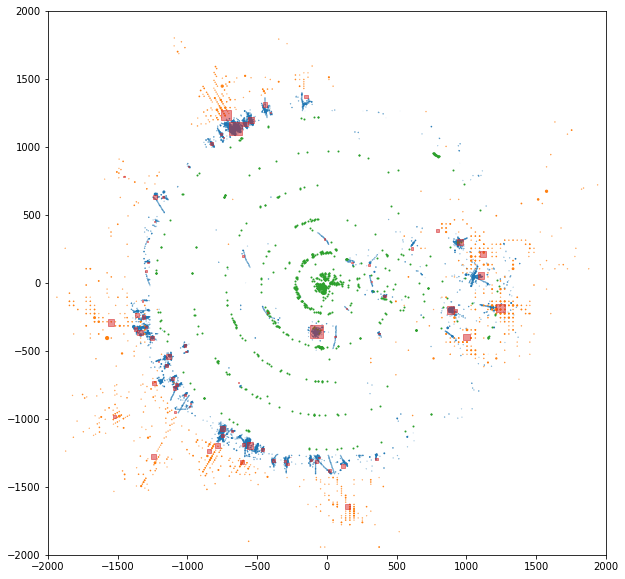

In [3]:
data = json.load(bz2.BZ2File("../testdata/pythia6_ttbar_0001_pandora_0.json.bz2", "r"))

iev = 0 #ith event
df_gen = pandas.DataFrame(data[iev]["genparticles"]) #Truth information electrons
#Data clic simulation. 
#we need particle flow date. Generated data .
# The data is 

# gen particles move to hits and ecal hits and so fourth
df_hit = pandas.DataFrame(data[iev]["track_hits"])#tracks compose of "hits"
df_cl = pandas.DataFrame(data[iev]["clusters"])
df_tr = pandas.DataFrame(data[iev]["tracks"])
df_ecal = pandas.DataFrame(data[iev]["ecal_hits"])
df_hcal = pandas.DataFrame(data[iev]["hcal_hits"])

df_pfs = pandas.DataFrame(data[iev]["pfs"])
#PFS is the data used.
    
plt.figure(figsize=(10,10))
plt.scatter(df_ecal["x"], df_ecal["y"], s=5*df_ecal["energy"]);#dark blue ecal deposits
plt.scatter(df_hcal["x"], df_hcal["y"], s=5*df_hcal["energy"]);#orange hcal deposits
#Charged and neutral hadrons may initiate a hadronic shower in the ECAL as well,
#which is subsequently fully absorbed in the hadron calorimeter (HCAL).
plt.scatter(df_hit["x"], df_hit["y"], s=1);#green tracker hits?
plt.scatter(df_cl["x"], df_cl["y"], s=5*df_cl["energy"], alpha=0.5, marker="s"); # red squares clusters energy depos? s is "markersize**2" So the squares

plt.xlim(-2000,2000)
plt.ylim(-2000,2000)

In [4]:
df_pfs 
#What are types. So the cluster_idx says to which cluster a particle 

,charge,cluster_idx,energy,px,py,pz,track_idx,type
0,0.0,0,0.503544,-0.353482,-0.320373,0.161146,-1,22
1,1.0,1,0.471189,-0.259074,-0.274876,0.244668,0,211
2,1.0,2,0.725461,-0.146924,0.523242,-0.459831,41,211
3,0.0,3,0.277013,-0.275606,-0.027047,0.006757,-1,22
4,0.0,4,0.691343,-0.184112,-0.067905,-0.662908,-1,2112
...,...,...,...,...,...,...,...,...
79,0.0,79,5.157015,-2.761861,-1.313529,4.152297,-1,22
80,-1.0,80,0.926568,-0.441712,0.655114,-0.463426,2,-211
81,-1.0,81,3.106948,1.182773,-0.018109,-2.869558,8,-211
82,0.0,82,0.179223,-0.122948,-0.113782,0.063706,-1,22


In [5]:
#is there a description of datasest event structure. Meaning what is cluster what is track hits etc? Still a question
#one event described
print(len(data[0]['clusters']))
print(len(data[0]['track_hits']))
print(len(data[0]["tracks"]))
print(len(data[0]["ecal_hits"]))



#What are clusters again?
# What is gp, gp_contributions?



84
848
43
6790


In [6]:
#An old detector note describing how to compute track parameters
#http://flc.desy.de/lcnotes/notes/localfsExplorer_read?currentPath=/afs/desy.de/group/flc/lcnotes/LC-DET-2006-004.pdf 
a = 3*10**-4
b = 5 #B-field in tesla



def track_pt(omega):
    return a*np.abs(b/omega)

In [7]:
#Create the genparticle -> track/cluster -> particle flow event graph
#Graph means. 
def event_to_graph(df_gen, df_cl, df_tr, df_pfs):
    g = nx.DiGraph()
    
    #Add genparticles
    for igen in range(len(df_gen)):
        g.add_node("gen{}".format(igen), typ=int(df_gen.iloc[igen]["pdgid"]), e=df_gen.iloc[igen]["energy"])

    #Add links to parents
    for igen in range(len(df_gen)):
        
        #Add links to parents
        idx_parent0 = int(df_gen.iloc[igen]["idx_parent0"])
        if idx_parent0 != -1:
            g.add_edge("gen{}".format(idx_parent0), "gen{}".format(igen), w=0)
            
        idx_parent1 = int(df_gen.iloc[igen]["idx_parent1"])
        if idx_parent1 != -1:
            g.add_edge("gen{}".format(idx_parent1), "gen{}".format(igen), w=0)
            
    #Add calorimeter clusters
    for icl in range(len(df_cl)):
        g.add_node(
            "clu{}".format(icl),
            typ=df_cl.iloc[icl]["type"],
            e=df_cl.iloc[icl]["energy"]
        )
        
        #Add links from genparticles to cluster
        #The weight is the energy contribution from the genparticle
        for gp, gp_w in df_cl.iloc[icl]["gp_contributions"].items():
            gp = int(gp)
            if gp_w/df_cl.iloc[icl]["energy"]>0.2:
                g.add_edge("gen{}".format(gp), "clu{}".format(icl), w=gp_w)

    #Add tracks
    for itr in range(len(df_tr)):
        g.add_node("tra{}".format(itr), typ=0, e=df_tr.iloc[itr]["pt"])
        
        #Add links from genparticles to track.
        #The weight is the number of hits in the track that came from this genparticle
        for gp, gp_w in df_tr.iloc[itr]["gp_contributions"].items():
            gp = int(gp)
            if gp_w/df_tr.iloc[itr]["nhits"]>0.2:
                g.add_edge("gen{}".format(gp), "tra{}".format(itr), w=gp_w)

    #Add PF objects
    for ipf in range(len(df_pfs)):
        g.add_node(
            "pfo{}".format(ipf),
            typ=int(df_pfs.iloc[ipf]["type"]),
            e=df_pfs.iloc[ipf]["energy"]
        )
        
        #Add link from cluster to PF object if available
        cl_idx = int(df_pfs.iloc[ipf]["cluster_idx"])
        if cl_idx!=-1:
            g.add_edge("clu{}".format(cl_idx), "pfo{}".format(ipf), w=0)

        #Add link from track to PF object if available
        tr_idx = int(df_pfs.iloc[ipf]["track_idx"])
        if tr_idx!=-1:
            g.add_edge("tra{}".format(tr_idx), "pfo{}".format(ipf), w=0)
    return g
#Can ignore this code basically. Reconstructing graph cahin

In [8]:
#Given the decay graph, estiamte the energy in each PF object that came from the generator-level tau
def get_tau_fractions(df_tau, df_pfs, g):
    
    tau_genparticles = [
        "gen{}".format(x) for x in df_tau.index
    ]
    
    energy_tau_tr = np.zeros_like(df_pfs["energy"])
    energy_tau_cl = np.zeros_like(df_pfs["energy"])
    
    for genp in tau_genparticles:
        
        #Get all the nodes reachable from this gen tau
        ng = nx.descendants(g, genp)
        
        #Find the particle flow objects downstream from the gen tau
        pfs = [node for node in ng if node.startswith("pfo")]
        
        #Loop over all the particle flow objects
        for pfpart in pfs:
            ipf = int(pfpart[3:])
            
            e_tr = 0.0
            e_cl = 0.0
            for pred in list(g.predecessors(pfpart)):
                
                #if this PF object came from a track, get the energy from the parent genparticle
                if pred.startswith('tra'):
                    track_preds = list(g.predecessors(pred))
                    for this_tr_pred in track_preds:
                        e_tr += g.nodes[this_tr_pred]["e"]
                        
                #if this PF object came from a cluster, get the energy from the edge
                elif pred.startswith('clu'):
                    cl_preds = list(g.predecessors(pred))
                    for this_cl_pred in cl_preds:
                        e_cl += g.edges[(this_cl_pred, pred)]["w"]
            
            energy_tau_tr[ipf] = e_tr
            energy_tau_cl[ipf] = e_cl
            
#             print("  {} {} E_pf={:.2f} E_tau_tr={:.2f} E_tau_cl={:.2f}".format(
#                 pfpart, g.nodes[pfpart]["typ"], g.nodes[pfpart]["e"], e_tr, e_cl)
#             )
    df_pf_taufracs = pandas.DataFrame()
    df_pf_taufracs["energy_tau_tr"] = energy_tau_tr
    df_pf_taufracs["energy_tau_cl"] = energy_tau_cl
    return df_pf_taufracs

#I dont need. Each PF canditade and how much comes from TAU.

In [9]:
def compute_track_properties(df_tr):
    df_tr["pt"] = track_pt(df_tr["omega"])
    df_tr["px"] = np.cos(df_tr["phi"])*df_tr["pt"]
    df_tr["py"] = np.sin(df_tr["phi"])*df_tr["pt"]
    df_tr["pz"] = df_tr["tan_lambda"]*df_tr["pt"]
    
#Properties of the tracks #read track properties if ypu want to use.

In [10]:
def computeJet(pfs_this_jet):
    p4sum = {'px':0, 'py':0, 'pz':0, 'energy':0 }
    for key in p4sum:
        for e in pfs_this_jet[key]:
            p4sum[key]+=e
    return vector.obj(x=p4sum['px'],y=p4sum['py'],z=p4sum['pz'],E=p4sum['energy'])

In [11]:
def process_one_event(data, iev):
    
    #Get the dataframes corresponding to this event
    df_gen = pandas.DataFrame(data[iev]["genparticles"])
    df_hit = pandas.DataFrame(data[iev]["track_hits"])
    df_cl = pandas.DataFrame(data[iev]["clusters"])
    df_tr = pandas.DataFrame(data[iev]["tracks"])
    df_ecal = pandas.DataFrame(data[iev]["ecal_hits"])
    df_hcal = pandas.DataFrame(data[iev]["hcal_hits"])
    df_pfs = pandas.DataFrame(data[iev]["pfs"])
    compute_track_properties(df_tr)#Might be useful

    #Get the generator taus with status==2
    #PDG= number assigned to generator particles
    #Status=2 mean this is the last tau in the decay chain. 
    df_tau = df_gen[(df_gen["pdgid"].abs()==15) & (df_gen["status"]==2)]
    
    #cluster the PF particles to jets, reorder by pt descending.
    cluster = fastjet.ClusterSequence(ak.Array({
        "px": df_pfs["px"],
        "py": df_pfs["py"],
        "pz": df_pfs["pz"],
        "E": df_pfs["energy"],
    }), jetdef)
    jets_constituents = cluster.constituent_index(min_pt=5)[::-1]
    #Usually anti k_t jets. 
    
    #Get the tau contributions in each PF object
    graph = event_to_graph(df_gen, df_cl, df_tr, df_pfs)
    df_pfs_taufrac = get_tau_fractions(df_gen, df_pfs, graph)
    
    #Now get the list of PF objects in each jet
    pfs_by_jet = []
    jets = []
    for jet_constituents in jets_constituents:
        
        #Get the PF objects corresponding to this jet
        pfs_jet = df_pfs.iloc[jet_constituents]
        pfs_jet_additional = df_pfs_taufrac.iloc[jet_constituents]
        pfs_this_jet = pandas.concat([pfs_jet, pfs_jet_additional], axis=1)
        pfs_by_jet.append(pfs_this_jet)
        jet = computeJet(pfs_this_jet)
        jets.append(jet)

    #return the gen taus, the computed jet, the list of PF candidates in each jet, cluster, tracks and genparticles
    return df_tau, jets, pfs_by_jet, df_cl, df_tr, df_gen
#pfs_by_jet

In [16]:
def filterPFS(pfs, df_cl, df_tr, df_gen): #quality criteria for pfs: https://cmssdt.cern.ch/lxr/source/RecoTauTag/RecoTau/python/PFRecoTauQualityCuts_cfi.py
    goodPFS =[]
    for ipf, pf in enumerate(pfs.iterrows()):
        pftype = abs(int(pf[1]['type']))
        if pftype == 211 or pftype == 11: #charged pion / electron 
            trackidx = int(pf[1]['track_idx'])
            if trackidx <0:
                print('faulty pf')
                continue
            if df_tr.iloc[trackidx]['pt']<0.5: continue # track pt cut
            if df_tr.iloc[trackidx]['z0']>0.4 : continue #dz cut, are these wrt primary vertex or detector center?
            if math.sqrt(max(0,df_tr.iloc[trackidx]['d0']**2-df_tr.iloc[trackidx]['z0']**2)) >0.1 : continue #dxy cut, are these wrt primary vertex or detector center?
            if df_tr.iloc[trackidx]['nhits']<5 : continue # nhits? do we need a chi2 cut ?
        elif pftype == 22 or pftype == 2112: #photon / pi0 / neutral hadron
            clusteridx = int(pf[1]['cluster_idx'])
            if clusteridx <0:
                print('faulty pf')
                continue
            tempPF = vector.obj(x=pf[1]['px'],y=pf[1]['py'],z=pf[1]['pz'],E=pf[1]['energy'])
            if tempPF.pt < 1 : continue
            if tempPF.pt < 30 and pftype == 2112 : continue
        goodPFS.append(pf)
    return goodPFS


def cleanJets(df_tau, jets, pfs_by_jet, df_cl, df_tr,df_gen, cleanPFS=True, recomputeJet=False, matchingCone=0.3, invertTau=False):
    matched_jets = []
    cleaned_pfs_by_matchedjet = []
    matched_tau = []
    leptonic=0
    hadronic=0
    for njet, jet in enumerate(jets):
        cleaned_pfs = pfs_by_jet[njet]
        if cleanPFS: cleaned_pfs = filterPFS(cleaned_pfs,df_cl, df_tr, df_gen)
        cleanedJet = jet
        if recomputeJet: cleanedJet = computeJet(cleaned_pfs)
        matchedTau = None
        matchedTau_index = -1
        
        #tau pdgid 15
        #Units in GeV
        
        
        #if len(df_tau)>1:
            #print(f'On küll suuremaid: {len(df_tau)}')
        for itau, tau in enumerate(df_tau.iterrows()):
    
            #print(tau[1])
            tempTau = vector.obj(x=tau[1]['px'],y=tau[1]['py'],z=tau[1]['pz'],E=tau[1]['energy'])
            #print(tempTau)
            #if tau is not hadronic then skip it-function needed iterate over df_gen
            #print(df_gen)
            #print(f'print df_tau:\n {df_tau}')
            if check_if_leptonic(df_tau,df_gen):
                leptonic+=1
                continue
            else:
                hadronic+=1
            
    
            if matchedTau is None:
                if tempTau.deltaR(cleanedJet)<matchingCone :
                    matchedTau=tempTau
                    matchedTau_index=itau 
        
            elif tempTau.deltaR(cleanedJet) < matchedTau.deltaR(cleanedJet) :
                
                matchedTau=tempTau
                matchedTau_index=itau
        if invertTau and matchedTau is None:
            matched_jets.append(cleanedJet)
            cleaned_pfs_by_matchedjet.append(cleaned_pfs)
        elif matchedTau is not None:
            matched_tau.append(df_tau.iloc[matchedTau_index])
            matched_jets.append(cleanedJet)
            cleaned_pfs_by_matchedjet.append(cleaned_pfs)
    return matched_tau, matched_jets, cleaned_pfs_by_matchedjet,df_gen,df_tau,leptonic,hadronic
#

# Process one event

In [21]:
data = json.load(bz2.BZ2File("../testdata/pythia6_ttbar_0001_pandora_4.json.bz2", "r"))
#data = json.load(bz2.BZ2File("/scratch-persistent/joosep/ml-tau-reco/clic/gev380ee_pythia6_ttbar_rfull201/pythia6_ttbar_0115_pandora_10.json.bz2", "r"))
ret = process_one_event(data, 3)
ret = cleanJets(ret[0], ret[1], ret[2], ret[3], ret[4], ret[5])
print(ret[0], ret[1], ret[2])
#df_gen=ret[3]
#df_tau=ret[4]
#Tau properties are printed
#name 22 is jets
#and below that PF canditaes. 
#pandora 4 event 3 even better.

charge            -1.000000
energy            21.064941
idx_parent0       85.000000
idx_parent1       -1.000000
mass               1.777000
pdgid             15.000000
pdgid_parent0   -511.000000
pdgid_parent1      0.000000
px               -16.135698
py                 6.168040
pz               -11.923444
status             2.000000
Name: 146, dtype: float64
charge            -1.000000
energy            21.064941
idx_parent0       85.000000
idx_parent1       -1.000000
mass               1.777000
pdgid             15.000000
pdgid_parent0   -511.000000
pdgid_parent1      0.000000
px               -16.135698
py                 6.168040
pz               -11.923444
status             2.000000
Name: 146, dtype: float64
charge            -1.000000
energy            21.064941
idx_parent0       85.000000
idx_parent1       -1.000000
mass               1.777000
pdgid             15.000000
pdgid_parent0   -511.000000
pdgid_parent1      0.000000
px               -16.135698
py                 6.168

charge            -1.000000
energy            21.064941
idx_parent0       85.000000
idx_parent1       -1.000000
mass               1.777000
pdgid             15.000000
pdgid_parent0   -511.000000
pdgid_parent1      0.000000
px               -16.135698
py                 6.168040
pz               -11.923444
status             2.000000
Name: 146, dtype: float64
charge            -1.000000
energy            21.064941
idx_parent0       85.000000
idx_parent1       -1.000000
mass               1.777000
pdgid             15.000000
pdgid_parent0   -511.000000
pdgid_parent1      0.000000
px               -16.135698
py                 6.168040
pz               -11.923444
status             2.000000
Name: 146, dtype: float64
charge            -1.000000
energy            21.064941
idx_parent0       85.000000
idx_parent1       -1.000000
mass               1.777000
pdgid             15.000000
pdgid_parent0   -511.000000
pdgid_parent1      0.000000
px               -16.135698
py                 6.168

charge            -1.000000
energy            21.064941
idx_parent0       85.000000
idx_parent1       -1.000000
mass               1.777000
pdgid             15.000000
pdgid_parent0   -511.000000
pdgid_parent1      0.000000
px               -16.135698
py                 6.168040
pz               -11.923444
status             2.000000
Name: 146, dtype: float64
charge            -1.000000
energy            21.064941
idx_parent0       85.000000
idx_parent1       -1.000000
mass               1.777000
pdgid             15.000000
pdgid_parent0   -511.000000
pdgid_parent1      0.000000
px               -16.135698
py                 6.168040
pz               -11.923444
status             2.000000
Name: 146, dtype: float64
charge            -1.000000
energy            21.064941
idx_parent0       85.000000
idx_parent1       -1.000000
mass               1.777000
pdgid             15.000000
pdgid_parent0   -511.000000
pdgid_parent1      0.000000
px               -16.135698
py                 6.168

charge            -1.000000
energy            21.064941
idx_parent0       85.000000
idx_parent1       -1.000000
mass               1.777000
pdgid             15.000000
pdgid_parent0   -511.000000
pdgid_parent1      0.000000
px               -16.135698
py                 6.168040
pz               -11.923444
status             2.000000
Name: 146, dtype: float64
charge            -1.000000
energy            21.064941
idx_parent0       85.000000
idx_parent1       -1.000000
mass               1.777000
pdgid             15.000000
pdgid_parent0   -511.000000
pdgid_parent1      0.000000
px               -16.135698
py                 6.168040
pz               -11.923444
status             2.000000
Name: 146, dtype: float64
charge            -1.000000
energy            21.064941
idx_parent0       85.000000
idx_parent1       -1.000000
mass               1.777000
pdgid             15.000000
pdgid_parent0   -511.000000
pdgid_parent1      0.000000
px               -16.135698
py                 6.168

charge            -1.000000
energy            21.064941
idx_parent0       85.000000
idx_parent1       -1.000000
mass               1.777000
pdgid             15.000000
pdgid_parent0   -511.000000
pdgid_parent1      0.000000
px               -16.135698
py                 6.168040
pz               -11.923444
status             2.000000
Name: 146, dtype: float64
charge            -1.000000
energy            21.064941
idx_parent0       85.000000
idx_parent1       -1.000000
mass               1.777000
pdgid             15.000000
pdgid_parent0   -511.000000
pdgid_parent1      0.000000
px               -16.135698
py                 6.168040
pz               -11.923444
status             2.000000
Name: 146, dtype: float64
charge            -1.000000
energy            21.064941
idx_parent0       85.000000
idx_parent1       -1.000000
mass               1.777000
pdgid             15.000000
pdgid_parent0   -511.000000
pdgid_parent1      0.000000
px               -16.135698
py                 6.168

In [ ]:
ret[4]


In [ ]:
check_if_leptonic(df_tau,df_gen)

In [ ]:
tau_daughters #pandora 4 event 3 even better.
#anti-electron neutrino, electron

In [ ]:
leptons=[11,12,13,14]
#res = any(ele in test_string for ele in test_list)#Returns True False
tau_daughters=[abs(i) for i in tau_daughters]
print(tau_daughters)
res = any(ele in tau_daughters for ele in leptons)
if any(ele in tau_daughters for ele in leptons):
    print("leptonic")

In [ ]:
#DeltaR test
examp1=ret[2][0][0][1]
examp2=ret[2][0][1][1]
examp2.type
vec1=getPF_lv(examp1)
vec2=getPF_lv(examp2)
#Dr (solid angle) leiad kahe vecktori lv vectori järgi
print(vec1.deltaR(vec2))
#pikalt on $\Delta R = \sqrt{\Delta\phi^2 + \Delta\eta^2}$
def deltaR(vec1,vec2):
    deltaR=np.sqrt((vec1.phi-vec2.phi)**2+(vec1.eta-vec2.eta)**2)
    return deltaR
print(deltaR(vec1,vec2))

# Strips
To reconstruct the full energy of the neutral pions, the electron and
photon candidates falling within a certain region of ∆η×∆φ are clustered together, with the
resulting object referred to as a “strip”. 

The initial position of the strip in the η − φ plane is set
according to the η and φ of the seed e or γ.

In [ ]:
#phi azimuthal angle(transverse plane) theta polar angle(parallel to z). 
#22-photon
#11-electron
#211-pion
#111- neutral pion

In [ ]:
#neutron code mean neutron. because you can not be sure.
#we have a tau and in the end i see charged pions and photons. 
# For mor events try to see if i can reimplement HPS. First try to do strips and plot out. 
#And try to understand whats going on. Negative masses would be bad :D. Maybe need to poke 
#filterPFS and clean jets but above them it I do not need. Strips with lists below jets. 
# ONE IMPORTANT THING: python functions for 4 vector moduls. DeltaR and shit like that.

# Help Functions

In [24]:
def get_e_and_y(event_pfs):
    #Funtion to get pf candidates that are photons or electrons
    e_and_y = []
    for pf in event_pfs:
        pf_type=abs(pf[1].type)
        if pf_type == 22 or pf_type == 11: #photon(22) or electron(11)
            #print(pf_type)
            #print(pf[1])
            e_and_y.append(pf[1])
            
    return e_and_y

def get_pions(event_pfs):
        #Funtion to get pf candidates that are pions
    pions = []
    for pf in event_pfs:
        pf_type=abs(pf[1].type)
        #print(pf_type)
        if pf_type == 111 or pf_type == 211: #pi^0(22) or pi^+(11)
            pions.append(pf[1])
    return pions  
def get_electrons(event_pfs):
    #Funtion to get pf candidates that are photons or electrons
    electrons = []
    for pf in event_pfs:
        pf_type=abs(pf[1].type)
        if pf_type == 11: #photon(22) or electron(11)
            #print(pf_type)
            #print(pf[1])
            electrons.append(pf[1])
    return electrons

def get_pf_mass(pf_obj):
    obj_lv=getPF_lv(pf_obj)#object lorentz vector
    mass=obj_lv.m #invariant mass of object
    return mass  

def get_invm(pf_obj):# just hands on version of previous mass function
    inv_m=np.sqrt((pf_obj.energy**2)-(pf_obj.px**2)-(pf_obj.py**2)-(pf_obj.pz**2))
    return inv_m

def deltaR(vec1,vec2):#hands on version of deltaR function
    deltaR=np.sqrt((vec1.phi-vec2.phi)**2+(vec1.eta-vec2.eta)**2)
    return deltaR

def getPF_lv(pf_obj):
    #Function for getting lorentz momentum vector from PF candidates
    lv = vector.obj(x=pf_obj['px'],y=pf_obj['py'],z=pf_obj['pz'],E=pf_obj['energy'])
    return lv

def get_all_PF_lv(pf_objects):
    #Function that converts and returns pf objects as lorentz vectors
    lvs=[]
    for obj in pf_objects:
        lvs.append(getPF_lv(obj))
    return lvs
def sort_by_pt(pf_objects):
    #Function that sorts pf objects by pt in descending order 
    #returns both lvs and pfs in same order
    PF_lv_objects=get_all_PF_lv(pf_objects)
    pts=[obj.pt for obj in PF_lv_objects]
    sorted_indx=sorted(range(len(pts)), reverse=True, key=lambda k: pts[k])#https://stackoverflow.com/questions/7851077/how-to-return-index-of-a-sorted-list
    sorted_lvs=[]
    sorted_pfs=[]
    for  indx in sorted_indx:
        sorted_lvs.append(PF_lv_objects[indx])
        sorted_pfs.append(pf_objects[indx])
        
    return sorted_lvs,sorted_pfs

def sort_by_pt2(lvs_objects):
    #Function that sorts pf objects by pt in descending order 
    #returns both lvs and pfs in same order
    pts=[obj.pt for obj in lvs_objects]
    sorted_indx=sorted(range(len(pts)), reverse=True, key=lambda k: pts[k])#https://stackoverflow.com/questions/7851077/how-to-return-index-of-a-sorted-list
    sorted_lvs=[]
    for  indx in sorted_indx:
        sorted_lvs.append(lvs_objects[indx])
        
    return sorted_lvs

def calc_strips_properties(all_strips):
    #Finction to calculate masses pts and etas of events
    masses=[]
    etas=[]
    pts=[]
    for event_strips in all_strips:
        #print(event_strips)
        if len(event_strips) > 1:
            for strip in event_strips:
                strip_mass=0
                strip_p4=vector.obj(x=0,y=0,z=0,E=0)
                strip_ptsum=0
                for strip_comp in strip['lvs']:
                    #print(strip_comp.mass)
                    strip_p4+=strip_comp
                    strip_ptsum+=strip_comp.pt# 
                    #strip_mass += strip_comp.mass
                    #print(strip_mass)
                    print(strip_ptsum)
                #If strip pt sum(not constituents lv) bigger than 2.5 
                #then it is a PI^0 candidate
                masses.append(strip_p4.mass)
                etas.append(strip_p4.eta)
                pts.append(strip_p4.pt)
                #prnt(masses)
                
                
        else:
            #print(event_strips[0]['lvs'])
            #print(event_strips[0]['lvs'][0].mass)
            masses.append(event_strips[0]['lvs'][0].mass)
    return masses,etas,pts

#event_pfs=ret[2][0]

def cal_strips_event(event_pfs):
    #Function returns strips as pf objects with thei complimentary lorentz vectros
    e_and_y=get_e_and_y(event_pfs)
    sorted_lvs,sorted_pfs=sort_by_pt(e_and_y)
    
    strips=[]
    while len(sorted_lvs) != 0:
        strip={ "lvs" : [] , "pfs" : []}
        strip['lvs'].append(sorted_lvs[0])
        strip['pfs'].append(sorted_pfs[0])
        seed_loc={ "eta" : sorted_lvs[0].eta, "phi" : sorted_lvs[0].phi}
        eta_bounds,phi_bounds=calc_window(seed_loc)
        del sorted_lvs[0],sorted_pfs[0] # remove from list so it will be easier to loop
    
        if len(sorted_lvs) ==1 :
            strip['lvs'].append(sorted_lvs[0])
            strip['pfs'].append(sorted_pfs[0])
        for i,lv in enumerate(sorted_lvs):
            #print(i)
            #print(lv)
            if check_if_in_window(lv,eta_bounds,phi_bounds) == True:
                #print('if True')
                #add to strip
                strip['lvs'].append(sorted_lvs[i])
                strip['pfs'].append(sorted_pfs[i])
                del sorted_lvs[0],sorted_pfs[0]
                #test_strip=strip
                strip_loc= calc_strip_loc(strip)
                #print(strip_loc)
                eta_bounds,phi_bounds=calc_window(strip_loc)
                #print(eta_bounds, phi_bounds)
            #else:
                #print('not in bounds')
        strips.append(strip)
    
    return strips

def calc_strip_loc(strip_lv_objects):
    strip_objects_eta=[obj.eta for obj in strip_lv_objects['lvs']]
    strip_objects_phi=[obj.phi for obj in strip_lv_objects['lvs']]
    #print(strip_objects_eta)
    #print(strip_objects_phi)
    #pf_object_eta=pf_object.eta
    #pf_object_phi=pf_object.phi
    strip_objects_pt= [obj.pt for obj in strip_lv_objects['lvs']]
    #pf_object_pt=pf_object.pt
    #pt_strip=pf_object_pt
    eta_mult=[*map(mul,strip_objects_pt,strip_objects_eta)]
    phi_mult=[*map(mul,strip_objects_pt,strip_objects_phi)]
    eta_strip=(1/sum(strip_objects_pt))*sum(eta_mult)
    phi_strip=(1/sum(strip_objects_pt))*sum(phi_mult)
    strip_loc={ "eta" : eta_strip, "phi" : phi_strip}
    return strip_loc

#Maybe calc_strip wrong. Lets see if we pu
        
def calc_window(seed_loc):
    #Function to calculate window for strip origin. Size (eta X phi)= (0.05 X 0.20)
    eta_bounds= [seed_loc['eta']-0.025, seed_loc['eta']+0.025]
    phi_bounds= [seed_loc['phi']-0.1, seed_loc['phi']+0.1]
    return eta_bounds,phi_bounds
def check_if_in_window(pf_object,eta_bounds,phi_bounds):
    #Function to check whether ovject is in strip origin window
    pf_object_eta=pf_object.eta
    pf_object_phi=pf_object.phi
    #print(pf_object_eta)
    #print(pf_object_phi)
    #print(eta_bounds[0],eta_bounds[1])
    if eta_bounds[0] < pf_object_eta < eta_bounds[1] and phi_bounds[0] < pf_object_phi < phi_bounds[1]:
        return True
    else:
        return False
    
    
#Taking a look at the daughters of the tau particle.
#Tau neutrino in every decay. Leptonical channel has muon, electron or their neutrinos.
#so events that have them i will classify them leptonic decay.
def check_if_leptonic(df_tau,df_gen):
    #Function to check if a decay is leptonic or hadronic
    #First f takes tau indx and then it tries to find gen particles with the
    #same parent particle indx as tau.
    leptons=[11,12,13,14]
    tau_daughters=[]
    tau_idx=df_tau.index
    for i,gen_id in enumerate(df_gen['idx_parent0']):
        #
        
        #print(f'gen_id: {gen_id} and tau_idx: {tau_idx}')
        #[print(df_gen.iloc[j]) for j in tau_idx]
        if gen_id == tau_idx:#.all():
            tau_daughters.append(df_gen['pdgid'].iloc[i])
    tau_daughters=[abs(i) for i in tau_daughters]
    result = any(ele in tau_daughters for ele in leptons)

    return result

def sum_lvs(lvs):
    #Function to add up lvs
    lv_sum=vector.obj(px=0,py=0,pz=0,E=0)
    for i,lv in enumerate(lvs):
        #print(lv)
        lv_sum+=lv
    return lv_sum

def calc_conedr(lv_pt):
    #Function to calculate cone for tau candidate.
    cone_dr=3.0/lv_pt
    if cone_dr<0.05:
        cone_dr=0.05
    if cone_dr>0.1:
        cone_dr=0.1
    return cone_dr

def get_strip_lv(strip_lvs):
    #get strip lorentz vector sum
    strip_lv=sum_lvs(strip_lvs)
    return strip_lv 

def pion2strip_umass(tau_cand_pt):
    #Function to calc upper mass limit for tau candidate in
    #charged hadron + TWO strips mode
    sroot=np.sqrt(tau_cand_pt/100)
    if sroot<=1:
        return 1.2
    if sroot>=1:
        mult=1.2*sroot
        
        if mult<4.0:
            return mult
        else:
            return 4.0
        
def pion2strip_umass2(tau_cand_pt):
    #Function to calc upper mass limit for tau candidate in
    #charged hadron + ONE strips mode
    sroot=np.sqrt(tau_cand_pt/100)
    if sroot<=1:
        return 1.3
    if sroot>=1:
        mult=1.3*sroot
        
        if mult<4.2:
            return mult
        else:
            return 4.2
def check_if_incone(pions, strips, pion_comb_indxs, strip_comb_indxs,cone,tau_cand_lv):
    #Function to determine whether something surrounds tau candidate in cone range
    #filter pions list from tau candidate 
    #print(f'cone: {cone}')
    for i,pion in enumerate(pions):
        if i in pion_comb_indxs:
            continue
        else:
            #check if something is in dr radius:
            dr_pion=tau_cand_lv.deltaR(getPF_lv(pion))
            #print(f'dr_pion: {dr_pion}')
        if dr_pion<cone:
            #print('pion_check')
            #so if anything in cone, break cycle and this candidate can be discarded
            return True
    #print(f'len strips: {len(strips)}')
    for i,strip in enumerate(strips):
        if i in strip_comb_indxs:
            continue
        else: 
            #print(strip)
            dr_strip=tau_cand_lv.deltaR(get_strip_lv(strip['lvs']))
            #print(f'dr_strip: {dr_strip}')
        if dr_strip<cone:
            #print('stripcheck')
            return True
    # If all checks fail then nothing is around 
    #print("reached end")
    return False
        
    

# Process all the data

In [ ]:
/scratch-persistent/joosep/ml-tau-reco/clic/gev380ee_pythia6_ttbar_rfull201/pythia6_ttbar_0115_pandora_10.json.bz2

In [ ]:
for fn in glob.glob("../testdata/*.json.bz2"):
    
    #Load the data file consisting of multiple events
    data = json.load(bz2.BZ2File(fn, "r"))
    
    #Loop over the events in the data file
    for iev in range(len(data)):
        #print(iev)
        process_one_event(data, iev)

### Calculate every events' strips. Result is "all_pions_strips2". It is list of events where each event is represtented by a dictionary: "charged hadrons", "taus" and "strips"

In [ ]:
pion_masses2=[]
electron_masses2=[]
all_pions2=[]
all_pions_strips2=[]
errors2=0
event_count2=0
hadronic2=0
leptonic2=0
more_than_1taus2=[]
for nf,fn in enumerate(glob.glob("/scratch-persistent/joosep/ml-tau-reco/clic/gev380ee_pythia6_ttbar_rfull201/*.json.bz2")):
    #print('teen')
    if not nf % 100: print("Event: "+str(nf))
    event_count2+=1
    #if nf > 10: # -->15 min
    #    break
    #Load the data file consisting of multiple events
    data = json.load(bz2.BZ2File(fn, "r"))
    
    #Loop over the events in the data file
    
    for iev in range(len(data)):
        #print(iev)
        event_count2+=1
        ret=process_one_event(data, iev)
        #ret = cleanJets(ret[0], ret[1], ret[2], ret[3], ret[4], ret[5])
        try:
            ret = cleanJets(ret[0], ret[1], ret[2], ret[3], ret[4], ret[5])
        except Exception:
            errors2 +=1
            #print(f'errors: {errors}')
            continue
        if len(ret[0])>1:
            #print("more than one taus")
            more_than_1taus2.append([ret[0], ret[1], ret[2]])       
        leptonic2+=ret[5]
        hadronic2+=ret[6]
        #print(f'length of ret {len(ret[2])}')
        if len(ret[2]):#if list contains something(Taus) do it:
            #print("Yeah contained something")
            taus=ret[0][0]
            jets=ret[1][0]
            event_pfs=ret[2][0]    
            pions=get_pions(event_pfs)
            #Create a dict that combines strips,taus,pions,jets of single event    
            #Add all pions to a list from which the tau candidates can be calculated
            strips_pions_taus={'strips' : [], 'pions' : pions ,'taus' : taus, 'jets' : jets}
            electrons=get_electrons(event_pfs)
            for el in electrons:
                electron_masses2.append(get_pf_mass(el)*10**3)# Adding pion masses
            for pion in pions:
                pion_masses2.append(get_pf_mass(pion)*10**3)# Adding pion masses
                
            strips=cal_strips_event(event_pfs)
            #print(len(strips))
            
            
            if len(strips)!=0: #some events contain only pions. Have to fix it right no just a patch with a if clause
                #So if strips has any length then add to memory. If not ignore
                #strips_pions_taus['strips'].append(strips)
                strips_pions_taus['strips']=strips
            #temptau error exception
            all_pions_strips2.append(strips_pions_taus)
            
        else: #if empty continue
            continue
            
        #print(f'errors:{errors} ')
        

Event: 0
Event: 100
Event: 200


### Following code is calculating four different decay modes for Taus. Like in section 5.1 in [paper](https://arxiv.org/pdf/1510.07488.pdf). Foe each event there might be multiple Tau candidates and in the end the candidate with highest PT is selected to represent certain event's final Tau candidate.

In [21]:
#Code to calculate all
#####3Charged particles
tau_candidates=[]
for evt in range(len(all_pions_strips2)):
    evt_tau_candidates=[]
    pions=all_pions_strips2[evt]['pions']
    #print(all_pions_strips[evt]['strips'])
    
    strips=all_pions_strips2[evt]['strips']
    strip_comb_indxs=[]
    pion_indxs=range(len(pions))
    strip_indxs=range(len(strips))
    ########################Three#charged#hadrons###########
    if len(pions)>2:
        print('more than two')
        #find subsets of three particles
        combs= list(itertools.combinations(pion_indxs, 3))
        #iterate through all combinations
        for i,pion_comb_indxs in enumerate(combs):
            #if charge abs(1) then continue:        
            charge_sum=sum([pions[i].charge for i in pion_comb_indxs])
            if abs(charge_sum)==1:
                #print('charge1')
                #now calculate mass of tau candidate(3 charged pions) from their 4-vector.
                lvs=[getPF_lv(pions[i]) for i in pion_comb_indxs]
                tau_cand_lv=sum_lvs(lvs)
                tau_cand_mass=tau_cand_lv.mass
                tau_cand_pt=tau_cand_lv.pt
                if 0.8<tau_cand_mass<1.5:
                    #print(f'evt: {evt}')
                    print('found  smthng')
                    #Calculate cone using formula and tau candidate pt
                    cone_dr=calc_conedr(tau_cand_pt)
                    result=check_if_incone(pions, strips, pion_comb_indxs, strip_comb_indxs,cone_dr,tau_cand_lv)
                    if result == False:
                        #Nothing surrounds the candidate
                        print('found candidate')
                        tau_candidate=tau_cand_lv
                        tau_candidates.append(tau_candidate)
    ######################Three#charged#hadron#END#############
    
    ######################One#charged#hadron#TWO#strips########
    if len(pions) >= 1 and len(strips) >= 2:
        #one charged hadron + two strips mode:     
        strip_combs=list(itertools.combinations(strip_indxs, 2))
        for i,pion in enumerate(pions):
            #iterate over all pions and match with two strip combination:
            for j,strip_comb_indxs in enumerate(strip_combs):
                #pion_lv=getPF_lv(pions[i])
                pion_lv=getPF_lv(pion)
                
                #print(strips[3])
                print(strip_comb_indxs[1])
                strips_lv=get_strip_lv(strips[strip_comb_indxs[0]]['lvs'])+get_strip_lv(strips[strip_comb_indxs[1]]['lvs'])
                tau_cand_lv=pion_lv+strips_lv
                tau_cand_mass=tau_cand_lv.mass
                tau_cand_pt=tau_cand_lv.pt
                
                #print(f'what this: {tau_cand_pt}')
                if 0.4 <tau_cand_mass<pion2strip_umass(tau_cand_pt):
                    #print(f'found something: {tau_cand_pt/100}')
                    cone_dr=calc_conedr(tau_cand_pt)
                    result=check_if_incone(pions, strips, pion_comb_indxs, strip_comb_indxs,cone_dr,tau_cand_lv)
                    if result == False:
                        #Nothing surrounds the candidate
                        print('found candidate')
                        tau_candidate=tau_cand_lv
                        tau_candidates.append(tau_candidate)
    ##############One#charged#hadron#TWO#strips#END############
    
    ###############One#charged#hadron#ONE#strips################
    if len(pions) >= 1 and len(strips) >=1:
        #No combinations needed Iterate over all possible hadron and strip
        #pairs
        for i,pion in enumerate(pions):
            for j,strip in enumerate(strips):
                pion_lv=getPF_lv(pion)
                strips_lv=get_strip_lv(strip['lvs'])
                tau_cand_lv=pion_lv+strips_lv
                tau_cand_mass=tau_cand_lv.mass
                tau_cand_pt=tau_cand_lv.pt
                
                if 0.3 < tau_cand_mass<pion2strip_umass2(tau_cand_pt):
                    cone_dr=calc_conedr(tau_cand_pt)
                    result=check_if_incone(pions, strips, pion_comb_indxs, strip_comb_indxs,cone_dr,tau_cand_lv)
                    if result == False:
                        #Nothing surrounds the candidate
                        print('found candidate')
                        tau_candidate=tau_cand_lv
                        tau_candidates.append(tau_candidate)
                     
    ###############One#charged#hadron#ONE#strips#END############
    
    ###############One#charged#hadron###########################
    if len(pions) != 0:
        for i,pion in enumerate(pions):
            pion_lv=getPF_lv(pion)
            tau_candidate=pion_lv
            tau_candidates.append(tau_candidate)
    ###############One#charged#hadron#END#######################
            
                

                
                
    
    #sort evt_candidates by pt and take the one with highest pt as candidate
    sorted_cands=sort_by_pt2(evt_tau_candidates)
    if len(sorted_cands)!=0:
        tau_candidates.append(sorted_cands[0])
                        

more than two
found  smthng
found candidate
more than two
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
1
2
3
4
2
3
4
3
4
4
1
2
found candidate
3
4
2
3
4
3
4
4
1
2
found candidate
3
4
2
3
4
3
4
4
1
2
3
4
2
3
4
3
4
4
1
2
3
4
2
3
4
3
4
4
1
2
3
4
2
3
4
3
4
4
found candidate
more than two
found  smthng
found  smthng
1
2
2
1
more than two
found  smthng
found candidate
more than two
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
1
1
1
1
1
1
more than two
found  smthng
found candidate
more than two
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found  smthng
found  smthng
foun

found candidate
more than two
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
more than two
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found  smthng
found candidate
1
found candidate
1
1
1
found candidate
1
found candidate
1
found candidate
found candidate
found candidate
found candidate
found candidate
found candidate
found candidate
found candidate
found candidate
more than two
1
2
3
2
3
3
1
2
3
2
3
3
found candidate
1
2
3
2
3
3
found candidate
found candidate
found candidate
found candidate
more than two
found  smthng
more than two
found  smthng
found candidate
more than two
found  smthng
found candidate
more than two
found  smthng
found candidate
more than two
found  smthng
found candidate
more than two
found  smthng
found candidate
more than two
found  smthng
found candidate
found  s

found candidate
found candidate
found candidate
found candidate
found candidate
more than two
found  smthng
found candidate
more than two
found  smthng
found  smthng
1
found candidate
2
3
4
2
3
4
3
4
4
1
2
3
4
2
3
4
3
4
4
1
2
3
4
2
3
found candidate
4
3
4
4
found candidate
1
2
3
4
found candidate
2
3
found candidate
4
3
4
4
found candidate
found candidate
found candidate
found candidate
more than two
found  smthng
found candidate
more than two
more than two
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
1
2
2
1
2
2
found candidate
found candidate
1
more than two
found  smthng
fo

3
1
2
3
2
3
3
1
2
3
2
3
3
more than two
found  smthng
found candidate
more than two
found  smthng
1
found candidate
1
found candidate
found candidate
found candidate
found candidate
more than two
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found candidate
1
1
found candidate
1
1
found candidate
1
1
found candidate
found candidate
found candidate
found candidate
more than two
found  smthng
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found candidate
found candidate
more than two
found  smthng
found candidate
more than two
found  smthng
found candidate
found  smthng
1
2
2
1
2
2
1
2
2
1
2
2
1
2
2
found candidate
found candidate
more than two
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smt

more than two
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
1
2
2
1
2
2
1
2
2
1
2
2
1
2
2
1
2
2
1
2
2
1
2
2
found candidate
found candidate
more than two
found  smthng
found candidate
more than two
more than two
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found  smthng
found candidat

1
1
more than two
found  smthng
found candidate
more than two
found  smthng
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found  smthng
found candidate
1
1
1
1
1
found candidate
found candidate
found candidate
found candidate
found candidate
found candidate
found candidate
found candidate
more than two
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found candidate
found  smthng
1
2
2
1
2
2
1
2
2
1
2
2
1
2
2
1
2
2
1
2
2
1
2
2
1
2
2
more than two
found  smthng
found candidate
found  smthng
found candidate
found  smthng
1
more than two
found  smthng
found candidate
more than two
found  smthng
found candidate
found  smthng
found  smthng
1
1
1
found candidate
1
found candidate
1
found candidate
found candidate
found candidate
found candidate
1
found candidate
1
found candidate
1
found candidate
1
found candidate
found candidate
found candidate
more than two
1
1
more tha

found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
1
1
more than two
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng


found candidate
found candidate
found candidate
more than two
found  smthng
found candidate
more than two
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
1
2
3
4
2
3
4
3
4
4
1
2
3
4
2
3
4
3
4
4
1
2
3
4
2
3
4
3
4
4
1
2
3
4
2
3
4
3
4
4
1
2
3
4
2
3
4
3
4
4
more than two
found  smthng
found candidate
1
found candidate
more than two
found  smthng
found candidate
more than two
found  smthng
more than two
1
found candidate
1
found candidate
1
found candidate
found candidate
found candidate
found candidate
found candidate
more than two
found  smthng
found candidate
1
found candidate
1
found candidate
1
found candidate
found candidate
found candidate
found candidate
found candidate
found candidate
found candidate
found candidate
1
found candidate
found candidate
more than two
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
foun

found candidate
1
found candidate
1
found candidate
found candidate
found candidate
more than two
found  smthng
found candidate
more than two
found  smthng
found candidate
found  smthng
1
1
found candidate
1
1
found candidate
1
found candidate
found candidate
found candidate
found candidate
found candidate
more than two
found candidate
found candidate
more than two
more than two
found  smthng
found candidate
found  smthng
found candidate
1
more than two
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
1
2
2
1
2
2
1
2
found candidate
2
found candidate
1
2
2
1
2
2
1
2
2
1
more than two
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
1
2
2
1
2
2
1
2
2
1
2
2
1
2
2
found candidate
1
2
2
found candidate
1
2
2
found candidate
found candidate
found candid

found candidate
3
found candidate
4
3
4
found candidate
4
found candidate
1
2
3
4
2
3
4
3
4
4
1
2
3
4
2
3
4
3
4
4
found candidate
found candidate
found candidate
found candidate
more than two
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
1
2
2
found candidate
1
2
2
1
2
2
1
2
2
1
2
2
1
2
2
more than two
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
1
2
3
2
3
3
1
2
3
2
3
3
1
2
3
2
3
3
1
2
3
2
3
3
1
2
3
2
3
3
1
2
3
2
3
3
1
1
more than two
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found 

found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
more than two
found  smthng
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found candidate
found candidate
found candidate
found candidate
1
more than two
found  smthng
found candidate
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
more than two
found  smthng
found  smthn

more than two
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found candidate
found  smthng
1
more than two
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
1
2
3
4
2
3
4
3
4
4
1
2
3
4
2
3
4
3
4
4
1
2
3
4
2
3
4
3
4
4
1
2
3
4
2
3
4
3
4
4
1
2
3
4
2
3
4
found candidate
3
4
4
1
2
3
4
2
3
4
3
4
4
1
2
found candidate
3
4
2
3
4
found candidate
3
found candidate
4
4
found candidate
1
2
3
4
2
3
4
3
4
4
found candidate
found candidate
found candidate
more than two
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found candidate
found candidate
found candidate
found candidate
1
found candidate
found candidate
found candidate
more than two
found  smthng
found candidate
found  smthng
foun

1
more than two
found  smthng
more than two
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found  smthng
1
2
2
found candidate
1
2
2
1
2
2
1
2
2
1
2
2
1
2
2
1
2
2
found candidate
found candidate
found candidate
found candidate
more than two
found  smthng
found candidate
more than two
found  smthng
1
found candidate
1
found candidate
1
found candidate
found candidate
found candidate
found candidate
found candidate
more than two
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
1
1
1
1
1
1
1
found candidate
1
more than two
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found candidate
1
2
found candidate
2
1
2
found candidate
2
found candidate
1
2
2
1
2
found candidate
2
1
2
2
found candidate


3
4
3
4
4
1
2
3
4
2
3
4
3
4
4
1
2
3
4
2
3
4
3
4
4
1
2
found candidate
3
4
2
3
4
3
4
4
1
2
found candidate
3
4
2
3
4
3
4
4
1
2
3
4
2
3
4
3
4
4
1
2
3
4
2
3
4
3
4
4
1
2
3
4
2
3
4
3
4
4
1
2
found candidate
3
4
2
3
4
3
4
4
1
2
found candidate
3
4
2
3
4
3
4
4
1
2
found candidate
3
4
2
3
4
3
4
4
1
2
found candidate
3
4
2
3
4
3
4
4
found candidate
found candidate
found candidate
found candidate
found candidate
found candidate
more than two
1
1
1
found candidate
found candidate
found candidate
found candidate
found candidate
more than two
found  smthng
1
2
3
4
2
3
4
3
4
4
1
2
3
4
2
3
4
3
4
4
1
2
3
4
2
3
4
3
4
4
1
2
3
4
2
3
4
3
4
4
found candidate
found candidate
found candidate
1
more than two
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found 

3
4
5
3
found candidate
4
5
4
5
5
1
2
3
4
5
2
3
4
5
3
found candidate
4
5
found candidate
4
5
found candidate
5
1
2
3
4
5
2
3
4
5
3
found candidate
4
found candidate
5
found candidate
4
found candidate
5
found candidate
5
found candidate
found candidate
found candidate
found candidate
found candidate
found candidate
found candidate
found candidate
found candidate
found candidate
found candidate
found candidate
found candidate
found candidate
more than two
found  smthng
more than two
found  smthng
found candidate
1
more than two
more than two
found  smthng
found candidate
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found candidate
found  smthng
found candidate
1
2
2
1
found candidate
2
2
1
found candidate
2
2
1
2
2
1
found candidate
2
2
found candidate
found candidate
found candidate
found candidate
more than two
found  smthng
found candidate
1
1
found candidate
1
found candidate
found candidate
found candidate
found candidate
more than two
foun

found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
1
2
3
4
5
6
7
8
9
10
11
2
3
4
5
6
7
8
9
10
11
3
4
5
6
7
8
9
10
11
4
5
6
7
8
9
10
11
5
6
7
8
9
10
11
6
7
8
9
10
11
7
8
9
10
11
8
9
10
11
9
10
11
10
11
11
1
2
3
4
5
6
7
8
9
10
11
2
3
4
5
6
7
8
9
10
11
3
4
5
found candidate
6
7
8
9
10
11
4
5
found candidate
6
7
8
9
10
11
5
6
7
8
9
10
11
6
7
found candidate
8
9
found candidate
10
11
7
8
9
10
11
8
9
10
11
9
10
11
10
11
11
1
2
3
4
5
6
7
8
9
10
11
2
3
4
5
6
7
8
9
10
11
3
4
5
6
7
8
9
10
11
4
5
6
7
8
9
10
11
5
6
7
8
9
10
11
6
7
8
9
10
11
7
8
9
10
11
8
9
10
11
9
10
11
10
11
11
1
2
3
4
5
6
7
8
9
10
11
2
3
4
5
6
7
8
9
10
11
3
4
5
6
7
8
9
10
11
4
5
6
7
8
9
10
11
5
6
7
8
9
10
11
6
7
8
9
10
11
7
8
9
10
11
8
9
10
11
9
10
11
10
11
11
1
2
3
4
5
6
7
8
9
10
11
2
3
4


1
2
2
1
2
2
more than two
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
more than two
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found candidate
1
more than two
found  smthng
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found candidate
found  smthng
1
2
2
1
2
2
1
2
2
1
2
2
1
2
2
1
2
2
1
2
2
1
2
2
found candidate
found candidate
more than two
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthn

2
3
4
2
3
4
3
4
4
1
2
3
4
2
3
4
3
4
4
1
2
3
4
2
3
4
3
4
4
1
2
3
4
2
3
4
3
4
4
1
2
3
4
2
3
4
3
4
4
1
2
3
4
2
3
4
3
4
4
1
2
3
4
2
3
4
3
4
4
1
2
3
4
2
3
4
3
4
4
1
2
3
4
2
3
4
3
4
4
1
2
3
4
2
3
4
3
4
4
1
2
3
4
2
3
4
3
4
4
found candidate
more than two
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
1
1
1
1
1
1
1
1
found candidate
1
more than two
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
1
2
3
4
5
2
3
4
5
3
4
5
4
5
5
1
2
3
4
5
2
3
4
5
3
4
5
4
5
5
1
2
3
4
5
2
3
4
5
3
4
5
4
5
5
1
2
3
4
5
2
3
4
5
3
4
5
4
5
5
found candidate
1
2
3
4
5
2
3
4
5
3
4
5
4
5
5
1
2
3
4
5
2
3
4
5
3
4
5
found candidate
4
5
5
found candidate
found candidate
found candidate
found candidate
found candidate
more than two
found  smthng
foun

more than two
found  smthng
1
found candidate
found candidate
more than two
found  smthng
found candidate
found candidate
more than two
found  smthng
1
2
2
1
2
2
1
2
2
1
2
2
1
2
2
more than two
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found  smthng
found candidate
found  smthng
1
2
2
1
2
2
1
2
2
1
2
2
1
2
2
1
2
2
1
2
2
1
2
2
1
2
2
1
2
2
found candidate
found candidate
found candidate
found candidate
found candidate
found candidate
more than two
found  smthng
found candidate
more than two
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng


found candidate
1
2
2
1
2
2
1
2
2
1
2
2
1
2
2
1
2
2
1
2
2
found candidate
more than two
found  smthng
found candidate
found  smthng
found candidate
1
1
found candidate
1
found candidate
1
found candidate
found candidate
found candidate
found candidate
found candidate
found candidate
found candidate
more than two
found  smthng
found candidate
more than two
found  smthng
found candidate
more than two
found  smthng
found candidate
more than two
found  smthng
found  smthng
found  smthng
1
2
3
2
3
3
1
2
3
2
3
3
1
2
3
2
3
found candidate
3
1
2
found candidate
3
2
found candidate
3
3
found candidate
found candidate
found candidate
1
more than two
found  smthng
found candidate
found  smthng
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found candidate
more than two
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
fo

found candidate
1
2
3
4
5
2
3
4
5
3
4
5
4
5
5
1
2
3
4
5
2
3
found candidate
4
5
found candidate
3
4
5
4
5
5
1
2
3
4
5
2
3
4
5
3
4
5
4
5
5
1
2
3
4
5
2
3
4
5
found candidate
3
4
5
4
5
5
found candidate
found candidate
found candidate
found candidate
found candidate
found candidate
found candidate
found candidate
more than two
1
2
3
2
3
3
found candidate
1
2
3
2
3
3
1
2
3
2
3
3
1
2
3
2
3
3
found candidate
1
2
3
2
3
3
found candidate
found candidate
found candidate
found candidate
found candidate
found candidate
found candidate
1
found candidate
1
2
3
2
3
3
more than two
found  smthng
1
found candidate
1
found candidate
1
found candidate
found candidate
found candidate
found candidate
more than two
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
1
2
2
1
found candidate
2
2
1
2
2
1
2
2
1
2
2
1
2
2
1


more than two
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
1
2
3
4
2
3
4
3
found candidate
4
4
1
2
3
4
2
found candidate
3
4
3
4
4
1
2
3
4
2
found candidate
3
found candidate
4
found candidate
3
4
4
1
2
3
4
2
3
4
3
4
4
1
2
3
4
2
3
4
3
4
4
1
2
3
4
2
3
4
3
4
4
1
2
3
4
2
3
4
3
4
4
found candidate
more than two
found  smthng
1
2
2
1
2
2
found candidate
1
2
2
found candidate
1
2
2
found candidate
found candidate
found candidate
found candidate
found candidate
found candidate
found candidate
found candidate
found candidate
found candidate
more than two
found  smthng
found candidate
1
1
found candidate
found candidate
more than two
found  smthng
found candidate
more than two
found  smthng
found candidate
more than two
found  smthng
found  smthng
fo

1
2
2
1
2
2
1
2
2
1
2
2
1
2
2
1
2
2
1
2
2
more than two
1
found candidate
found candidate
found candidate
more than two
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
1
2
2
1
2
2
1
2
2
1
2
2
1
2
2
1
2
2
found candidate
1
2
2
1
2
2
1
2
2
1
2
2
found candidate
found candidate
found candidate
found candidate
1
more than two
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found 

2
2
1
2
2
found candidate
1
2
2
1
2
2
1
2
2
1
2
2
found candidate
found candidate
found candidate
found candidate
found candidate
found candidate
found candidate
found candidate
found candidate
found candidate
found candidate
1
found candidate
found candidate
1
more than two
found  smthng
found candidate
1
1
found candidate
found candidate
more than two
found  smthng
found candidate
more than two
found  smthng
1
found candidate
1
more than two
found  smthng
found candidate
found candidate
more than two
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found candidate
found  smthng
found  smthng


found candidate
2
3
2
3
3
1
2
3
2
3
3
1
2
3
2
3
3
found candidate
found candidate
found candidate
more than two
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found  smthng
found candidate
found  smthng
1
2
found candidate
3
2
3
3
more than two
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found candidate
found  smthng
1
2
2
1
2
2
1
2
2
1
2
2
1
2
2
found candidate
found candidate
found candidate
found candidate
found candidate
1
2
2
more than two
found  smthng
found candidate
found  smthng
found  smthng
found  smthng
found  smthng
found candidate
1
1
1
1
1
1
1
2
3
2
3
3
1
2
3
2
3
3
more than two
found candidate
found candidate
more than two
found  smthng
found candidate
more than two
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found 

4
3
4
4
1
2
3
4
2
3
4
3
4
4
1
2
3
4
2
3
4
3
4
4
1
2
3
4
2
3
4
3
4
4
1
2
3
4
2
3
4
3
4
4
found candidate
found candidate
found candidate
more than two
found  smthng
found candidate
found  smthng
found candidate
1
1
1
1
1
found candidate
found candidate
found candidate
more than two
found candidate
1
found candidate
found candidate
more than two
found  smthng
found candidate
found  smthng
found  smthng
1
2
2
found candidate
1
2
2
found candidate
1
2
2
1
2
2
1
2
2
found candidate
found candidate
1
1
2
found candidate
2
found candidate
more than two
found  smthng
more than two
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
foun

2
found candidate
3
2
found candidate
3
3
found candidate
found candidate
found candidate
found candidate
more than two
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthn

found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
1
2
3
4
5
2
3
4
5
3
4
5
4
5
5
1
2
3
4
5
2
3
4
5
3
4
5
4
5
5
1
2
3
4
5
2
3
4
5
3
4
5
4
5
5
1
2
3
4
5
2
3
4
5
3
found candidate
4
5
4
5
5
1
2
3
4
5
2
3
4
5
3
4
5
4
5
5
found candidate
1
2
3
4
5
2
3
4
found candidate
5
3
4
5
4
5
found candidate
5
found candidate
found candidate
found candidate
found candidate
found candidate
more than two
more than two
found  smthng
found  smthng
found  smthng
1
1
1
1
1
more than two
found  smthng
found candidate
1
found candidate
found candidate
found candidate
more than two
found  smthng
1
found candidate
2
3
found candidate
4
5
2
3
4
5
3
4
5
4
5
5
1
2
3
4
5
2
3
4
5
3
4
5
4
5
5
1
found candidate
2
3
found candidate
4
5
2
3
4
5
3
4
5
4
5
5
1
found candidate
2
3
found candidate
4
5
found candidate
2
3
4
5
3
4
5
4
5
5
1
2
3
found candidate
4
5
2
3
4
5
3
4
5
4
5
5
1
2
3
4
5
2
3
4
5
3
4
5
4
5
5
found candidate
found candidate
found candidate
found candidate
1
more than two
more than two
fo

found candidate
found candidate
found candidate
found candidate
more than two
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
1
found candidate
1
1
found candidate
1
found candidate
1
found candidate
found candidate
found candidate
found candidate
found candidate
found candidate
found candidate
more than two
found  smthng
found candidate
1
found candidate
found candidate
found candidate
more than two
found  smthng
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
1
2
3
2
3
3
1
2
3
2
3
3
1
2
3
2
3
3
1
2
3
2
3
3
1
2
3
2
3
3
1
more than two
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found cand

3
3
1
2
3
2
3
3
1
2
3
2
3
3
1
2
3
2
3
3
1
2
3
2
3
3
1
2
3
2
3
3
1
2
3
2
3
3
1
2
3
2
3
3
1
2
3
2
3
3
1
2
3
2
3
3
more than two
more than two
found  smthng
found candidate
more than two
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
1
2
2
1
2
2
1
2
2
1
2
2
1
2
2
found candidate
more than two
found  smthng
found candidate
1
found candidate
found candidate
more than two
found  smthng
found candidate
found  smthng
found candidate
1
2
2
1
2
2
1
2
2
1
2
2
1
2
2
1
2
found candidate
2
1
2
2
more than two
found  smthng
found candidate
more than two
found  smthng
found candidate
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
1
1
found candidate
1
found candidate
1
found candidate
1
1
found candidate
found candidate
found candidate
found candidate
more than two
1
2
3


more than two
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
1
2
3
4
2
3
4
3
4
4
1
2
3
4
2
found candidate
3
4
found candidate
3
4
4
1
2
3
4
2
3
4
3
4
4
1
2
3
4
2
3
4
3
4
4
1
2
3
4
2
found candidate
3
4
found candidate
3
found candidate
4
found candidate
4
1
2
3
4
2
3
4
3
4
4
1
2
3
4
2
3
4
3
4
4
found candidate
found candidate
found candidate
found candidate
more than two
more than two
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
more than two
found  smthng
found candidate
more than two
found  smthng
found candidate
found candidate
more than two
found  smthng
1
1
1
found candidate
found candidate
found candidate
more than two
more than two
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smt

more than two
found  smthng
found  smthng
found  smthng
1
2
2
1
2
2
1
2
2
1
2
2
1
2
2
found candidate
found candidate
found candidate
found candidate
1
more than two
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
1
2
2
1
2
2
1
2
2
1
2
2
1
2
2
1
2
2
1
2
2
1
2
2
more than two
found  smthng
found candidate
more than two
found  smthng
found candidate
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found  smthng
found  smthng
found  smthng
foun

3
4
5
4
5
5
1
2
3
4
5
2
3
4
5
3
4
5
4
5
5
1
2
3
4
5
2
3
4
5
3
4
5
4
5
5
1
2
3
4
5
2
3
4
5
3
4
5
4
5
5
1
2
3
4
5
2
3
4
5
3
4
5
4
5
5
1
2
3
4
5
2
3
4
5
3
4
5
4
5
5
1
2
3
4
5
2
3
4
5
3
4
5
4
5
5
found candidate
found candidate
found candidate
1
1
found candidate
found candidate
found candidate
more than two
found  smthng
found candidate
more than two
found  smthng
found candidate
found  smthng
found candidate
1
1
1
1
1
1
1
found candidate
found candidate
found candidate
1
found candidate
1
more than two
found  smthng
more than two
found  smthng
found candidate
more than two
found  smthng
found  smthng
1
1
1
1
1
found candidate
found candidate
found candidate
more than two
more than two
more than two
found  smthng
found candidate
1
2
2
more than two
found  smthng
found candidate
found  smthng
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found  smthng
found candidate
found  smthng
found candidate
found 

more than two
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found  smthng
1
1
1
1
1
1
1
found candidate
found candidate
found candidate
found candidate
found candidate
found candidate
1
more than two
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found candidate
1
2
3
4
2
3
4
3
4
4
1
2
3
4
2
3
4
3
4
4
1
2
3
4
2
3
4
found candidate
3
4
4
1
2
3
4
2
3
4
3
4
4
1
2
3
4
2
found candidate
3
found candidate
4
found candidate
3
4
found candidate
4
1
2
3
4
2
3
4
found candidate
3
4
4
found candidate
found candidate
found candidate
more than two
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
foun

5
6
3
4
5
6
4
5
6
5
6
6
1
2
3
4
5
6
2
3
4
5
6
3
4
5
6
4
5
6
5
6
6
1
2
3
4
5
6
2
3
4
5
6
3
4
5
6
4
5
6
5
6
6
1
2
3
4
5
6
2
3
4
5
6
3
4
5
6
4
5
6
5
6
6
1
2
3
4
5
6
2
3
4
5
6
3
4
5
6
4
5
6
5
6
6
1
2
3
4
5
6
2
3
4
5
6
3
4
5
6
4
5
6
5
6
6
1
2
3
4
5
6
2
3
4
5
6
3
4
5
6
4
5
6
5
6
6
1
2
3
4
5
6
2
3
4
5
6
3
4
5
6
4
5
6
5
6
6
1
2
3
4
5
6
2
3
4
5
6
3
4
5
6
4
5
6
5
6
6
found candidate
more than two
found  smthng
found candidate
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found  smthng
found candidate
1
found candidate
2
2
1
found candidate
2
2
1
found candidate
2
found candidate
2
1
2
2
1
2
found candidate
2
1
2
2
found candidate
found candidate
found candidate
more than two
found  smthng
found candidate
more than two
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found candidate
found  s

found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
1
1
1
1
1
1
1
1
1
1
2
3
2
3
3
more than two
found  smthng
found candidate
1
found candidate
found candidate
found candidate
more than two
found  smthng
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found candidate
found candidate
1
more than two
found  smthng
1
1
1
1
1
1
2
2
1
2
2
found candidate
found candidate
found ca

found candidate
found candidate
found candidate
more than two
more than two
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
1
2
3
2
3
3
1
2
3
2
3
3
1
2
3
2
3
found candidate
3
1
2
3
2
3
3
1
2
3
2
3
found candidate
3
more than two
found  smthng
found candidate
found candidate
more than two
found  smthng
found candidate
more than two
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
1
2
2
1
2
2
1
2
2
1
2
2
found candidate
1
2
found candidate
2
found candidate
found candidate
found candidate
found candidate
found candidate
found candidate
more than two
found  smthng
found candidate
found  smthng
1
1
1
1
found candidate
found candidate
found candidate
found candidate
found candidate
more than two
more than two
found  smthng
found candidate
more than two
1
1
found candidate
1
found candidate
found candidate
found candidate
found candidate
found candidate
found candidate
more than two
found  smt

found candidate
1
2
2
more than two
1
2
found candidate
2
1
2
2
found candidate
1
2
found candidate
2
found candidate
found candidate
found candidate
found candidate
more than two
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found  smthng
1
2
2
1
2
2
1
2
2
1
2
2
1
2
2
found candidate
found candidate
found candidate
more than two
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found  smthng
1
2
2
1
2
2
1
2
2
1
2
2
1
2
2
1
2
2
found candidate
found candidate
found candidate
found candidate
more than two
found  smthng
more than two
found  smthng
found candidate
found candidate
more than two
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
1
1
1
1
1
1
1
found cand

2
2
1
2
2
more than two
found  smthng
found  smthng
1
1
1
1
found candidate
more than two
found  smthng
found candidate
1
found candidate
found candidate
found candidate
1
found candidate
found candidate
more than two
found  smthng
more than two
1
2
3
4
2
3
4
3
4
4
1
2
3
4
2
3
4
3
4
4
1
2
3
4
2
3
4
3
4
4
found candidate
more than two
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found candidate
more than two
found  smthng
found candidate
more than two
found  smthng
1
2
3
4
5
2
3
4
5
3
4
5
4
5
5
1
2
3
4
5
2
3
4
5
3
4
5
4
5
5
more than two
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
1
2
2
1
2
2
1
2
2
1
2
2
found candidate
1
2
2
found candidate
more than two
1
2
2
1
2
2
1
2
2
1
2
2
1
2
2
found candidate
found candidate
found candidate
more than two
1
2
2
found candidate
1
2
2
1
2
2
found candidate
found candidate
found candidate
found candidate
found candidate
1
found candidate
foun

found candidate
more than two
found  smthng
found candidate
more than two
found  smthng
found candidate
more than two
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
1
2
3
2
3
3
1
2
3
2
3
3
1
2
3
2
3
3
1
2
3
2
3
3
1
found candidate
2
3
2
3
found candidate
3
found candidate
more than two
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
1
2
3
2
3
3
found candidate
1
2
3
2
3
3
found candidate
1
2
3
2
3
3
1
2
3
2
3
3
1
2
3
2
3
3
found candidate
1
2
3
2
3
3
found candidate
found candidate
found candidate
found candidate
found candidate
found candidate
found candidate
found candidate
found candidate
more than two
found  smthng
found candidate
1
2
2
found candidate
1
found candidate
2
2
found candidate
1
2
2
found candidate
found candidate
found candidate
found candidate
found candidate
found candidate
more than two
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found 

3
1
2
3
2
3
3
1
2
3
2
3
3
1
2
3
2
3
3
1
2
3
2
found candidate
3
3
found candidate
found candidate
more than two
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
1
1
found candidate
1
found candidate
1
1
found candidate
1
found candidate
found candidate
found candidate
found candidate
found candidate
found candidate
found candidate
found candidate
found candidate
found candidate
found candidate
found candidate
more than two
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
foun

found candidate
more than two
found  smthng
found candidate
found  smthng
1
2
3
4
2
3
4
3
4
4
1
2
3
4
2
3
4
3
4
4
1
2
3
4
2
3
4
3
4
4
1
2
3
4
2
3
4
3
4
4
found candidate
found candidate
more than two
found  smthng
found candidate
more than two
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
1
2
2
1
2
2
1
2
2
1
2
2
1
2
2
1
2
2
more than two
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng


3
found candidate
4
5
found candidate
3
4
5
4
5
5
1
2
3
4
5
2
3
4
5
3
4
5
4
5
5
1
2
3
4
5
2
3
4
5
3
4
5
4
5
5
1
2
3
4
5
2
3
4
5
3
4
5
4
5
5
1
2
3
4
5
2
3
found candidate
4
5
found candidate
3
4
5
4
5
5
1
2
3
4
5
2
3
4
5
3
4
5
4
found candidate
5
5
1
2
3
4
5
2
3
4
5
3
4
5
4
5
found candidate
5
found candidate
found candidate
found candidate
found candidate
found candidate
found candidate
found candidate
more than two
found  smthng
more than two
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  s

found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
1
1
1
1
1
1
1
found candidate
found candidate
found candidate
1
2
3
2
3
3
1
2
3
2
3
3
more than two
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
foun

found candidate
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
foun

found candidate
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
1
1
1
1
1
1
1
1
1
more than two
found  smthng
found candidate
more than two
found  smthng
found  smthng
found  smthng
1
2
2
1
2
2
1
2
2
1
2
2
1
2
2
found candidate
found candidate
found candidate
more than two
found  smthng
found  smthng
found  smthng
found  smthng
found candidate
1
2
2
1
2
2
1
2
2
1
2
2
1
2
2
1
2
2
1
2
2
1
2
2
1
2
2
more than two
found  smthng
found candidate
found candidate
more than two
found  smthng
found candidate
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found  smthng
found  smthng
found  smthng
1
found candidate
1
found candidate
1
1
found candidate
1
found candidate
1
found candidate
1
found candidate
found 

found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
1
2
3
4
2
3
4
3
4
4
1
2
3
4
2
3
4
3
4
4
1
2
3
4
2
3
4
3
4
4
1
2
3
4
2
3
4
3
4
4
found candidate
1
2
3
4
2
3
4
3
4
4
1
2
3
4
2
3
4
3
4
4
1
2
3
4
2
3
4
3
4
4
1
2
3
4
2
3
4
3
4
4
1
2
3
4
2
3
4
3
4
4
1
2
3
4
2
3
4


1
2
2
more than two
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
1
2
3


found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthn

5
5
found candidate
1
2
2
found candidate
1
2
2
found candidate
found candidate
found candidate
found candidate
more than two
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
1
2
3
4
5
6
7
2
3
4
5
6
7
3
4
5
6
7
4
5
6
7
5
6
7
6
7
7
1
2
3
4
5
6
7
2
3
4
5
6
7
3
4
5
6
7
4
5
6
7
5
6
7
6
7
7
1
2
3
4
5
6
7
2
3
4
5
6
7
3
4
5
6
7
4
5
6
7
5
6


2
3
4
5
2
3
4
5
3
4
5
4
5
5
1
2
3
4
5
2
3
4
5
3
4
5
4
5
5
1
2
3
4
5
2
3
4
5
3
4
5
4
5
5
1
2
3
4
5
2
3
4
5
3
4
5
4
5
5
found candidate
more than two
1
2
3
2
3
3
1
2
3
2
3
3
1
2
3
2
3
3
found candidate
found candidate
more than two
found  smthng
found candidate
found  smthng
found candidate
more than two
found  smthng
1
2
2
found candidate
1
2
2
found candidate
1
2
2
found candidate
found candidate
found candidate
more than two
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found  smthng
found candidate
found  smthng
1
found candidate
2
2
1
2
2
found candidate
1
2
2
found candidate
1
2
2
found candidate
1
2
found candidate
2
found candidate
found candidate
found candidate
found candidate
more than two
found  smthng
found candidate
more than two
found  smthng
found candidate
more than two
found  smthng
found candidate
more than two
found  smthng
found candidate
found  smthng
found candidate
1
2
3
2
3
3
found candidate
1
2
3
2
3
foun

1
2
3
2
3
3
found candidate
found candidate
found candidate
found candidate
more than two
found  smthng
found candidate
1
found candidate
1
found candidate
1
found candidate
found candidate
found candidate
found candidate
found candidate
found candidate
more than two
found  smthng
found candidate
more than two
found  smthng
1
2
2
1
found candidate
2
2
1
found candidate
2
2
more than two
found  smthng
more than two
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
1
2
2
1
2
found candidate
2
found candidate
1
2
found candidate
2
1
2
2
1
2
2
1
2
found candidate
2
found candidate
found candidate
found candidate
found candidate
more than two
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  s

found  smthng
1
2
3
4
5
2
found candidate
3
4
5
found candidate
3
4
5
4
5
5
1
2
3
4
5
2
3
4
5
found candidate
3
4
5
4
5
5
1
2
3
4
5
2
found candidate
3
4
5
found candidate
3
4
5
found candidate
4
5
5
1
2
3
4
5
2
found candidate
3
4
5
found candidate
3
4
5
4
5
5
1
2
3
4
5
2
3
4
5
3
4
5
4
5
5
1
2
3
4
5
2
found candidate
3
found candidate
4
5
found candidate
3
found candidate
4
5
4
5
found candidate
5
found candidate
found candidate
found candidate
found candidate
more than two
1
found candidate
found candidate
found candidate
1
found candidate
found candidate
more than two
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
1
2
3
2
3
3
1
2
3
2
3
3
1
2
3
2
3
3
1
2
3
2
3
3
1
2
3
2
3
3
1
found candidate
2
3
2
3
3
1
2
3
2
3
3
more than two
found  smthng


1
2
2
more than two
found  smthng
found candidate
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
1
2
3
2
3
3
1
2
3
2
3
3
1
2
3
2
3
found candidate
3
found candidate
1
2
3
2
3
3
1
2
3
2
found candidate
3
3
1
2
3
2
3
3
1
2
3
2
3
3
1
2
3
2
3
3
1
2
3
2
3
3
found candidate
found candidate
found candidate
found candidate
more than two
found  smthng
found  smthng
found  smthng
1
1
1
1
found candidate
more than two
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
1
2
2
1
2
2
1
2
2
1
2
2
1
2
2
1
2
2
1
2
2
1
2
2
more than two
found  smthng
found candidate
more than two
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  s

found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
1
2
3
4
5
2
3
4
5
3
4
5
4
5
5
1
2
3
4
5
2
3
4
5
3
4
5
4
5
5
1
2
3
4
5
2
3
4
5
3
4
5
4
5
5
1
2
3
4
5
2
3
4
5
3
4
5
4
5
5
found candidate
1
2
3
4
5
2
3
4
5
3
4
5
4
5
5
1
2
3
4
5
2
3
4
5
3
found candidate
4
5
4
5
found candidate
5
found candidate
1
2
3
4
5
2
3
4
5
3
4
5
4
5
5
1
2
3
4
5
2
3
4
5
3
found candidate
4
5
4
5
5
1
2
3
4
5
2
3
4
5
3
4
5
4
5
5
1
more than two
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found candidate
found  smthng
found ca

more than two
found  smthng
found candidate
more than two
found  smthng
found candidate
found candidate
found candidate
more than two
1
1
found candidate
1
found candidate
1
found candidate
found candidate
found candidate
found candidate
found candidate
found candidate
found candidate
1
more than two
1
found candidate
found candidate
more than two
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found candidate
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found  smthng
found candidate
found  smthng


In [20]:
print(f'Leptonic decays: {leptonic2}')
print(f'Hadronic decays: {hadronic2}')
print(f'Percentage of leptonic decays: {round(leptonic2/(hadronic2+leptonic2)*100,2)}%')
#Leptonic should be circa 35.21% So correct

Leptonic decays: 16034
Hadronic decays: 29637
Percentage of leptonic decays: 35.11%


In [ ]:
# Previous fn are actually events. 3600 fails

In [24]:
all_strips=[all_pions_strips2[i]['strips'] for i in range(len(all_pions_strips2)) if len(all_pions_strips2[i]['strips'])!=0]
all_strips[0]

[{'lvs': [vector.obj(px=3.0854408740997314, py=-8.076114654541016, pz=-5.481196880340576, E=10.236556053161621)],
  'pfs': [charge            0.000000
   cluster_idx      71.000000
   energy           10.236556
   px                3.085441
   py               -8.076115
   pz               -5.481197
   track_idx        -1.000000
   type             22.000000
   energy_tau_tr     0.000000
   energy_tau_cl    10.160981
   Name: 71, dtype: float64]},
 {'lvs': [vector.obj(px=1.9997923374176025, py=-6.506129741668701, pz=-3.244563102722168, E=7.540297508239746)],
  'pfs': [charge            1.000000
   cluster_idx      92.000000
   energy            7.540298
   px                1.999792
   py               -6.506130
   pz               -3.244563
   track_idx        41.000000
   type            -11.000000
   energy_tau_tr     7.533410
   energy_tau_cl     2.905407
   Name: 92, dtype: float64]},
 {'lvs': [vector.obj(px=1.1280665397644043, py=-3.9355275630950928, pz=-2.240521192550659, E=4.66

In [25]:
strip_masses,strip_etas,strip_pts=calc_strips_properties(all_strips)

8.645436559298638
6.806533156330041
4.094009198575064
1.648447986748167
3.2525717564974532
1.6041237697492863
4.6404716722361465
8.31699741639494
3.12232603956921
5.022343883271539
1.9000178437023294
12.7483307634458
14.908670845897607
2.160340082451807
14.325499799330402
15.59470782761057
1.2692080282801679
4.91921754931832
3.691775399689116
2.6712276857697694
1.6275135306354174
1.3525606022199608
1.182274612128308
2.2642918054736914
1.082017193345383
7.512041276561302
9.341347904290128
1.8293066277288257
4.627785848161767
6.067129829640889
1.4393439814791218
6.427419107259128
2.888748607659282
4.125114030078022
5.361479452496762
3.8515007738123144
6.133017904217718
2.281517130405404
16.808891938809413
20.727269872838562
3.9183779340291474
9.96370082661948
6.1620755704268575
4.518222369540259
2.0896892299644216
3.3763479861090313
1.2866587561446097
4.751830034348284
6.750139036667626
1.998309002319342
10.712874306607304
11.779180984861851
1.1937743732098662
2.260081051464413
1.0663066

11.738701859907353
14.711216653202188
2.9725147932948346
2.651981469282877
1.1733754819502236
2.344491968031469
1.1711164860812455
1.2119291726754156
2.419819799171872
1.2078906264964568
12.98139899558197
1.8568877405624291
3.124647451900489
1.2677597113380599
16.14511386403375
20.959159585052113
4.814045721018365
21.70967095610412
2.3437774276689516
0.8128981863771947
1.4525674945563865
0.6396693081791918
2.4492287168587112
4.142749901433241
1.6935211845745304
2.187598471265286
4.017854426726899
1.830255955461613
15.427667691314511
1.36988085442305
2.5692963887659666
1.1994155343429163
3.7178410751509414
3.70794397954624
5.083257096446282
1.3753131169000414
11.370832243140642
13.933319474945858
2.562487231805216
8.98130910453235
9.992363258999596
1.0110541544672451
7.366975106941925
3.3552223651636086
2.6951327379412446
4.34164369367115
1.646510955729906
2.7744973239374033
1.1279863682074973
5.772215352549239
2.75394708118296
4.895825812542819
7.037704543902678
2.7952043047553135
4.23

1.0901293512972516
10.594683410615135
3.6832278658895796
5.622523309668806
1.939295443779227
2.511582953690808
3.7897545278698366
1.2781715741790287
4.386484157233053
3.0545326479835246
4.646370425724511
1.5918377777409862
5.110422480370728
7.528313481433871
2.417891001063143
14.570553515096085
16.32911708733981
1.7585635722437254
8.912898610675656
3.660811512702774
1.5806557281555411
1.2048248397921721
2.3524965231133805
1.1476716833212082
17.579981206655766
18.72978778415724
1.1498065775014705
11.463878951037863
4.635262842097596
3.0167618767459126
3.9777082927343557
0.9609464159884431
37.229006140334576
39.43067458269986
2.2016684423652833
2.675199249137098
4.431848581154199
1.7566493320171006
24.892690648034264
1.8591515831466594
1.8364412151074394
1.5308967610689417
2.6577365550277334
1.1268397939587917
2.3107140694985935
1.7571391414460973
2.847346910708784
1.0902077692626864
11.548387595571317
5.313752866994846
2.883213592553655
3.9757387672824196
1.0925251747287643
9.3365246396

5.09736201416486
1.0652996014679774
9.283117545176811
8.67458849858098
4.168959176851697
2.2295413412899134
3.4704318381102954
1.2408904968203818
1.4257450003146326
2.7064043820997856
1.280659381785153
35.43059994027511
36.97286713572611
1.542267195451007
5.8447956867783875
2.259877114389998
4.1126240531632945
1.2117430063812615
2.378658064864476
2.1133808688074835
3.1722628190897373
1.0588819502822535
5.173966059711554
6.611880366349837
1.4379143066382827
18.573254039122816
24.126556401170845
5.553302362048031
8.90991430345523
11.35965470644588
2.4497404029906518
50.37030554197739
56.79064305079277
4.842198638205815
30.71498488856034
34.43413843310758
3.719153544547236
5.238467283404507
1.519313738857271
1.9607211568690468
3.2887131998635213
1.3279920429944745
3.9506106956970553
2.9642698901637106
4.044774109433574
1.0805042192698626
4.5843992825520505
2.5209523820676765
2.2513262217854013
1.8657310225598298
1.8521910738451635
3.0028868025959454
1.150695728750782
8.96328714503626
5.84

2.8921849242831703
1.2855944429640993
10.398573191393725
1.996382140498417
3.733913050988427
5.471443961478437
10.190313896175866
16.32604262298295
17.883675777880974
3.239548483140356
1.8160171814188226
3.2466114193873645
1.4305942379685421
5.565591625381698
4.417770768598674
6.390329673198538
1.299188439316356
14.517114645663684
22.092789804443825
4.37454619831871
6.130275757407218
7.886005316495726
2.571151428505996
4.091126636831634
1.5199752083256377
2.409245527825424
1.305694925717913
2.608632965726314
1.3029380400084012
2.0074671346050965
1.8443873139246543
3.5248582448728114
1.6804709309481571
4.4211163297830005
6.581401930397439
2.1602856006144386
20.06998154338476
22.452584599703975
2.382603056319214
2.0270521886227573
3.2076980855870243
1.1806458969642668
22.535035157849546
24.942436246459756
2.407401088610212
10.21581106548083
12.182922439623878
1.9671113741430486
2.6077763186298024
1.4071065479911065
1.346656271576693
2.614953214893082
1.2682969433163889
7.2745291875454505

1.1498788220814566
6.459145577004407
5.6669294841926625
6.9116900787890465
1.244760594596384
13.164283143467166
12.003989965162774
3.3216498775056174
5.4038092427565
2.0821593652508823
2.2677577490083416
1.9987577679648858
1.7066975352105407
3.071314027497931
1.3646164922873902
1.6780220088018267
2.8724375146913115
1.1944155058894848
4.316259637899555
5.39135896209754
1.0750993241979845
22.170902570067966
23.202412542089707
1.2859110137020902
1.2401439667504426
2.2716539387721832
1.0315099720217404
4.726358619380687
6.7560882718666315
2.029729652485945
28.695331005951516
30.939158413710494
2.2438274077589795
12.29800738546472
16.213344848581976
2.280894353621564
9.312118265502368
2.4488967676060858
4.47271348494986
2.023816717343774
11.918189374856896
4.15881654079571
5.513853207063499
1.3550366662677884
10.741455737193466
11.432219334462859
0.6907635972693933
22.50067722499724
23.733681093553393
1.2330038685561515
5.778418960433047
3.862916788626902
5.532127246275904
1.669210457649001

8.078116080460333
3.608423854072835
4.956282635811606
3.1797945551643956
3.0045257923126707
2.233263588344835
1.3959765754193116
2.1879777702284757
0.7920011948091641
2.79324840387392
4.445614664861939
1.6523662609880188
8.440928898907696
10.52954834973795
2.088619450830254
12.314918783360177
2.7206173297373413
5.398794078829669
8.076970827921997
18.912867417792
22.275655723082288
3.3627883052902887
2.1052633007255928
3.3171148564610142
1.2118515557354217
3.044759667857367
4.742071491043438
1.697311823186071
13.436932651296015
7.792461757847836
8.880955737283067
4.227741614446727
1.3872806898847743
2.475774669320005
1.0884939794352306
4.508106456177394
3.4513710308672776
4.12011809106066
0.6687470601933826
16.26790088171788
1.8667207110695185
1.1718828097098357
2.3218084334443834
1.1499256237345479
6.49474508042713
7.969138883611289
1.474393803184159
4.345320280520763
7.377700054991692
3.032379774470929
4.253493123476311
1.5631792592624731
2.789438595327047
1.2262593360645735
3.9418057

3.40646980694674
0.736488559565391
4.958620496026024
6.209310359342644
1.2506898633166201
4.603553106093407
4.395680634575292
5.906945480450618
1.511264845875326
11.402052594814526
3.88686069683617
1.4277934688409843
2.840303217352176
4.2528129658633675
2.774167110880672
5.202068349075187
2.4279012381945146
4.307616647240303
6.051073725448
1.7434570782076972
8.407655538499428
4.291146418652729
2.959020541468138
2.5929418962001844
1.9712040867385492
2.9980499711204365
1.026845884381887
12.161457202425394
3.125027014309332
4.790040905537027
1.6650138912276946
8.687436973892044
12.604640725207611
15.028946018010883
2.4243052928032713
4.180053955665129
3.0096394613337067
2.06476228123488
3.155309356772505
1.090547075537625
1.7830426667383705
3.0260237277332083
1.2429810609948377
7.118398581221672
11.888645481847401
3.0962643328357897
1.5209892934059817
1.3624105661068477
2.498376488749752
1.1359659226429044
8.587345959456377
14.748281044831579
5.9351331872054285
3.273456579080222
4.4563242

14.756961374175914
16.08690980152654
1.3299484273506268
7.518618206812064
9.92317402759394
2.404555820781876
3.4233235267931286
1.4580310790849695
2.4767987850962223
1.3208060170798985
1.1915229395535036
2.210290645564756
1.0187677060112525
16.183789324162912
4.714931536350378
1.3818644437556422
2.475885614638765
1.094021170883123
5.8353238660527875
5.0423527420113246
6.232680991893705
1.1903282498823806
1.9679021358618307
1.7004705801876854
2.7482358723454263
1.0477652921577412
9.979428643280743
5.715621772731136
1.7674295458772855
2.9155221465137204
1.148092600636435
5.0381951216190135
6.060898816561705
1.0227036949426913
4.600190593422745
5.486824142056091
0.886633548633346
4.437237915078608
8.813538064881266
2.3568316116487846
3.5440814633922697
4.731331315135755
1.1158033743860496
2.193194831675995
1.0773914572899455
2.9291633002776662
4.6647391415386865
1.7355758412610203
1.8339698389770693
2.8967321341688654
1.062762295191796
28.252579530644145
4.505222639457581
6.22038071395992

13.964583432397513
1.6066021768835042
12.453784013590528
16.339928349102404
3.376454461554305
6.004539246188418
2.6280847846341135
1.7680331456857021
1.1482966264406511
1.0139628827764013
1.681640297633515
0.6676774148571136
4.45515448387824
3.3741105227026025
6.2443284993507895
2.870217976648187
9.735082677369991
5.303745094669528
7.93703918131857
2.633294086649042
32.36776504172055
34.45129693687667
2.083531895156124
15.969353002846475
18.231583626856327
2.2622306240098515
4.087286076304522
6.235253764117401
1.106278317413212
4.657472120504675
7.510058338567129
2.8525862180624535
4.230961457912662
5.898951293686248
1.0286727310532848
51.77233912698367
63.870052015715245
2.027326487674299
1.9071445847317643
3.0823968984122816
1.175252313680517
2.1796392177518773
3.338736472242866
1.1590972544909888
8.551195419916825
13.116165664880027
3.7436607479954342
5.648438472486598
1.904777724491164
18.81235125543503
8.54114545418052
5.829334132324249
2.5249148377753086
1.7962947282967978
2.8268

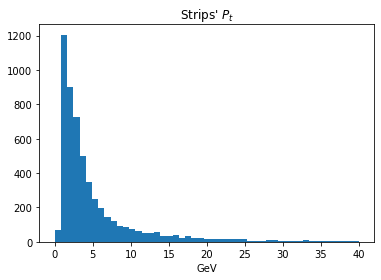

In [26]:
#strip ptss
from matplotlib import pyplot as plt
bins=np.linspace(0,40,50)
#strip_pts_mev=[strip_pt*10**3 for strip_pt in strip_pts]
plt.hist(strip_pts,bins=bins)
plt.xlabel('GeV')
plt.title('Strips\' $P_{t}$')
#plt.savefig('/home/aadi/ml-tau-reco/plots/plots_03_08/strips_pts.png')
plt.show()
#1.5 MeV low mass combined electron and brem and resolution error. Still a good approx?
#ask Joosep why?

In [ ]:
#loc and scale in python mean and std

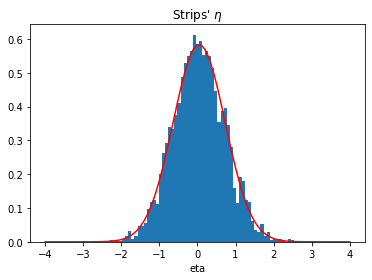

In [27]:
#strip etas
from scipy import stats
from matplotlib import pyplot as plt
bins=np.linspace(-4,4,100)
#strip_pts_mev=[strip_pt*10**3 for strip_pt in strip_pts]
plt.hist(strip_etas,bins=bins,density=True)
plt.xlabel('eta')
plt.title('Strips\' $\eta$')

loc,scale=stats.norm.fit(strip_etas)
x=np.linspace(-4,4,100)
pdf=stats.norm.pdf(x,loc=loc,scale=scale)
plt.plot(x,pdf,color='red')
#plt.show()
#plt.savefig('/home/aadi/ml-tau-reco/plots/plots_03_08/strips_etas.png')
#1.5 MeV low mass combined electron and brem and resolution error. Still a good approx?
#ask Joosep why?

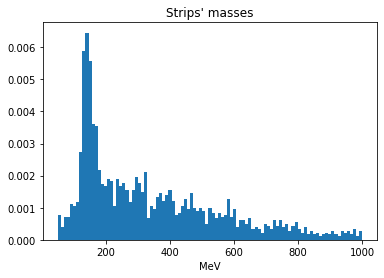

In [28]:
#strip masses
from matplotlib import pyplot as plt
bins=np.linspace(50,1000,100)
strip_masses_mev=[strip_mass*10**3 for strip_mass in strip_masses]
plt.hist(strip_masses_mev,bins=bins,density=True)



plt.xlabel('MeV')
plt.title('Strips\' masses')

#plt.savefig('/home/aadi/ml-tau-reco/plots/plots_03_08/strips_masses.png')
plt.show()
#1.5 MeV low mass combined electron and brem and resolution error. Still a good approx?
#ask Joosep why?

In [ ]:
#bigger mev = n-pions 150 MeV
#plot eta and phi
#Do it on all events etas and phis.

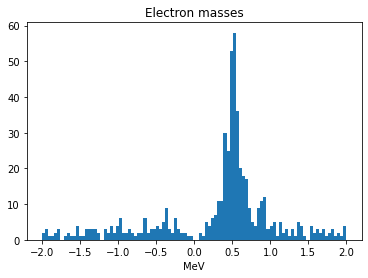

In [29]:
#electron masses
from matplotlib import pyplot as plt
bins=np.linspace(-2,2,100)
plt.hist(electron_masses2,bins=bins)
plt.xlabel('MeV')
plt.title('Electron masses')
plt.savefig('/home/aadi/ml-tau-reco/plots/plots_03_08/electron_masses.png')
plt.show()
#1.5 MeV low mass combined electron and brem and resolution error. Still a good approx?
#ask Joosep why?

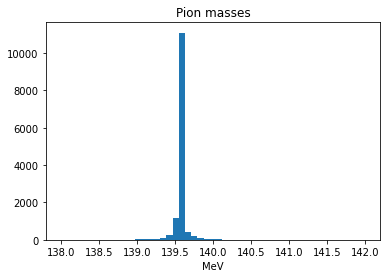

In [30]:
#pion masses
from matplotlib import pyplot as plt
bins=np.linspace(138,142,50)
plt.hist(pion_masses2,bins=bins)
plt.xlabel('MeV')
#plt.savefig('/home/aadi/ml-tau-reco/plots/plots_03_08/pion_masses.png')
plt.title('Pion masses')
plt.show()

In [31]:
print(f'Leptonic decays: {leptonic2}')
print(f'Hadronic decays: {hadronic2}')
print(f'Percentage of leptonic decays: {round(leptonic2/(hadronic2+leptonic2)*100,2)}%')
#Leptonic should be circa 35.21% So correct

Leptonic decays: 16034
Hadronic decays: 29637
Percentage of leptonic decays: 35.11%


In [ ]:
#Lets do the first combinatorics. 3 charged pions charge  must be 1.
#So two same and one opposite charge.
#all_pions_strips[1]['pions'][0]-six pions
#test_pions
#pions=all_pions_strips[1]['pions'][0]
#test_pions=all_pions_strips[1]['pions'][0]
#def ch_pions_comb(pions):
#####3Charged particles
tau_candidates2=[]
for evt in range(len(all_pions_strips2)):
    evt_tau_candidates2=[]
    pions=all_pions_strips2[evt]['pions']
    #print(all_pions_strips[evt]['strips'])
    
    strips=all_pions_strips2[evt]['strips']
    strip_comb_indxs=[]
    pion_indxs=range(len(pions))
    strip_indxs=range(len(strips))
    if len(pions)>2:#if more than two pions, then 3 pions candidates are possible.
        print('more than two')
        #Three charged hadron mode
        #find subsets of three particles
        combs= list(itertools.combinations(pion_indxs, 3))
        #iterate through all combinations
        for i,pion_comb_indxs in enumerate(combs):
            #if charge abs(1) then continue:        
            charge_sum=sum([pions[i].charge for i in pion_comb_indxs])
            if abs(charge_sum)==1:
                #print('charge1')
                #now calculate mass of tau candidate(3 charged pions) from their 4-vector.
                lvs=[getPF_lv(pions[i]) for i in pion_comb_indxs]
                tau_cand_lv=sum_lvs(lvs)
                tau_cand_mass=tau_cand_lv.mass
                tau_cand_pt=tau_cand_lv.pt
                if 0.8<tau_cand_mass<1.5:
                    print(f'evt: {evt}')
                    print('found  smthng')
                    #Calculate cone using formula and tau candidate pt
                    cone_dr=calc_conedr(tau_cand_pt)
                    result=check_if_incone(pions, strips, pion_comb_indxs, strip_comb_indxs,cone_dr,tau_cand_lv)
                    if result == False:
                        #Nothing surrounds the candidate
                        print('found something true!!!')
                        tau_candidate=tau_cand_lv
                        evt_tau_candidates2.append(tau_candidate)
    if len(pions)=>1 and len(strips)>=2:
        #one charged hadron + two strips mode:
        
        strip_combs=list(itertools.combinations(strip_indxs, 2))
        for i,pion enumerate(pions):
            #iterate over all pions and match with two strip combination:
            for j,strip_comb_indxs in enumerate(strip_combs):
                pion_lv=getPF_lv(pions[i])
                strips_lv=get_strip_lv(strip_comb_indxs[0])+get_strip_lv(strip_comb_indxs[1])
                print(strips_lv)
            
        Vale
    
    
    
        #sort evt_candidates by pt and take the one with highest pt as candidate
        sorted_cands=sort_by_pt2(evt_tau_candidates2)
        if len(sorted_cands)!=0:
            tau_candidates2.append(sorted_cands[0])

In [ ]:
print(errors2)
print(len(more_than_1taus2))

In [33]:
cand_masses=[cand.mass for cand in tau_candidates2]

NameError: name 'tau_candidates2' is not defined

In [ ]:
len(cand_masses)
#Length before sorting 3340
#after cleaning 1166

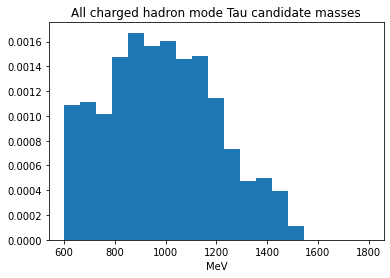

In [32]:
#cand masses
from matplotlib import pyplot as plt
bins=np.linspace(600,1800,20)
cand_masses=[cand.mass for cand in tau_candidates]
#strip_masses_mev=[strip_mass*10**3 for strip_mass in strip_masses]
cand_masses_mev=[cand_mass*10**3 for cand_mass in cand_masses]
plt.hist(cand_masses_mev,bins=bins,density=True)



plt.xlabel('MeV')
plt.title('All charged hadron mode Tau candidate masses')

#plt.savefig('/home/aadi/ml-tau-reco/plots/plots_03_08/strips_masses.png')
plt.show()
#before was around 1,2.

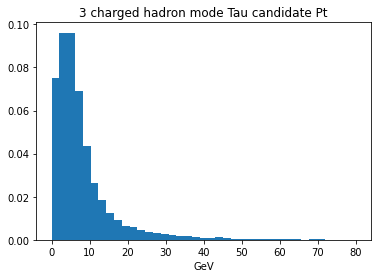

In [34]:
#cand pts
from matplotlib import pyplot as plt
bins=np.linspace(0,80,40)
cand_pts=[cand.pt for cand in tau_candidates]
#strip_masses_mev=[strip_mass*10**3 for strip_mass in strip_masses]
#cand_masses_mev=[cand_mass*10**3 for cand_mass in cand_masses]
plt.hist(cand_pts,bins=bins,density=True)



plt.xlabel('GeV')
plt.title('3 charged hadron mode Tau candidate Pt')

#plt.savefig('/home/aadi/ml-tau-reco/plots/plots_03_08/strips_masses.png')

plt.show()

In [ ]:
#gen particles Taus distributions for comparison

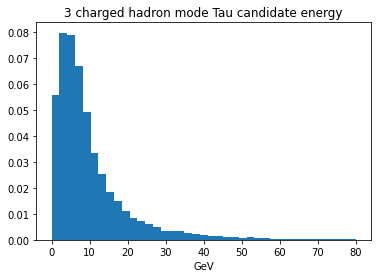

In [35]:
#https://arxiv.org/pdf/1510.07488.pdf#cand energy
from matplotlib import pyplot as plt
bins=np.linspace(0,80,40)
cand_energy=[cand.energy for cand in tau_candidates]
#strip_masses_mev=[strip_mass*10**3 for strip_mass in strip_masses]
#cand_masses_mev=[cand_mass*10**3 for cand_mass in cand_masses]
plt.hist(cand_energy,bins=bins,density=True)



plt.xlabel('GeV')
plt.title('3 charged hadron mode Tau candidate energy')

#plt.savefig('/home/aadi/ml-tau-reco/plots/plots_03_08/strips_masses.png')
plt.show()